In [939]:
%load_ext autoreload
%autoreload 2
import os
import glob
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
pd.options.display.max_columns = 999
import sys
sys.path.append("../../Code")
import vader
import settings as s
import utils 
import seaborn as sns 
import afinns as af
import s140
import opinion_lexicon as op
import so_cal as sc
import sentiment as sent
import analysis
import languages as lang

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


abnbvocab =  pd.read_csv(os.path.join('..','..', 'Tools','mydict.tsv'), delimiter="\t", index_col=0)


wordset = set(abnbvocab.index)

from nltk import sent_tokenize

interrater_reviews= interrater_reviews.dropna()

len(interrater_reviews)

allsents = []
for i, r in interrater_reviews.iterrows():
    sents = sent_tokenize(r['comments'])
    new_sents = []
    for s in sents:
        inter = set(utils.tokenize(s.lower())).intersection(wordset)
        if len(inter) > 0:
            new_sents.append(s)
    allsents.append(" ".join(new_sents))

interrater_reviews['new_comments'] = allsents

pd.options.display.max_colwidth = 1000

interrater_reviews['new_scores'] = interrater_reviews.new_comments.map(lambda x: op.get_score(x))

interrater_reviews = interrater_reviews.drop('comments', axis=1).join(reviews[['id', 'comments']].set_index('id'), on='id')

interrater_reviews = interrater_reviews.join(reviews[['id', 'opinion_bow']].set_index('id'), on='id')

interrater_reviews

# Load Data

In [495]:
reviews = pd.read_csv('reviews_with_sent_corrected.csv', index_col=0)

In [574]:
reviews = reviews.rename(columns={c:c.replace("-", "_") for c in reviews.columns})

In [575]:
len(reviews)

225090

In [443]:
whole_score_table[main_tools].corr()

,afinn,vader,s140,so_cal,opinion_bow
afinn,1.000000,0.500379,0.382556,0.080085,0.029456
vader,0.500379,1.000000,0.455416,0.302443,0.229699
s140,0.382556,0.455416,1.000000,0.274058,0.170898
so_cal,0.080085,0.302443,0.274058,1.000000,0.416561
opinion_bow,0.029456,0.229699,0.170898,0.416561,1.000000


In [8]:
def voter_counts(src_tbl, voters):
    counts = {'total': len(src_tbl)}
    for voter in voters:
        counts[voter] = len(src_tbl[src_tbl[voter] == src_tbl['vote']])
    return pd.DataFrame(counts,index=[0])

In [9]:
def join_multi_table(tbls, chosen):
    result = tbls[0][['id', 'comments', chosen[0]]]
    for i, t in zip(range(1, len(tbls)), tbls[1:]):
        result = result.join(t[['id', chosen[i]]].set_index('id'), on='id')
    return result

In [1026]:
from scipy import stats
def majority_vote(src_tbl, voters):
    src_tbl['vote'] = np.round(np.average(src_tbl[voters], axis=1))
    return src_tbl

In [11]:
def normalise_tools(tbl, tools):
    tbl.is_copy = False
    for t in tools:
        tbl[t] = utils.minmaxscale(tbl[t])
    return tbl

In [12]:
def normalise_tools_sent(tbl, tools):
    tbl.is_copy = False
    for t in tools:
        tbl[t] = utils.minmaxscale_sent(tbl, t, True)
    return tbl

In [13]:
def plot_distributions(tbl, tools):
    for t in tools:
        sns.distplot(tbl[t].astype(float))
        plt.show()

# Whole reviews

In [500]:
tools = ['afinn', 'vader', 's140', 'so_cal', 'opinion_bow']

In [505]:
from IPython.core.display import HTML, display_html

In [565]:
def perform_analysis(reviews, tool_settings):
    tools = list(tool_settings.keys())
    
    score_table = reviews[['id', 'comments']+tools]
    display_html(score_table[tools].describe())
    score_table = normalise_tools(score_table, tools)
    plot_distributions(score_table, tools)
    for t in tools:
        score_table = utils.transform_tool(score_table, t, tool_settings[t]['transform'], tool_settings[t]['clip'])
        if tool_settings[t]['transform'] != None:
            sns.distplot(score_table[t+'_transformed'])
            plt.show()
        else:
            sns.distplot(score_table[t])
            plt.show()
    level_tools = [t+'_transformed' if tool_settings[t]['transform'] != None else t for t in tools]
    return (score_table, level_tools)

In [564]:
def get_levels(scores, tools, level):
    levels_table =analysis.build_levels_table(scores, tools, type=2 if level == 3 else 1)
    voters_level = [ "level" +str(level) + "_"  + t for t in tools] #'level_so_cal-norm',
    value_counts = pd.DataFrame([levels_table[t].value_counts() for t in voters_level])
    display_html(value_counts)
    return (levels_table, voters_level)

In [1224]:
whole_tool_settings = { 
    'afinn':{'transform':'log', 'clip': 'outer'},
    'vader':{'transform':'exp', 'clip': None}, 
    's140':{'transform':None, 'clip': None},
    'so_cal':{'transform':'log', 'clip': 'outer'},
    'opinion_bow':{'transform':'log', 'clip': 'outer'} 
}

sent_tool_settings = {
    'afinn_sent': {'transform': 'log', 'clip': 'outer'},
    'vader_sent': {'transform':'log', 'clip': None},
    's140_sent': {'transform':None, 'clip': None},
    'so_cal_sent':{ 'transform': 'log', 'clip': 'outer'},
    'opinion_bow_sent':{'transform':'log', 'clip': 'outer'}  
}

,afinn,vader,s140,so_cal,opinion_bow
count,225090.000000,225090.000000,225090.000000,225090.000000,225090.000000
mean,11.943489,0.864315,3.273464,2.608295,0.218137
std,7.813055,0.229136,1.164391,1.540444,0.123153
min,-35.000000,-0.996400,0.000000,-15.000000,-1.000000
25%,7.000000,0.859100,2.000000,1.800936,0.137255
50%,11.000000,0.938400,4.000000,2.500000,0.200000
75%,16.000000,0.971200,4.000000,3.280000,0.285714
max,116.000000,0.999600,4.000000,20.000000,1.000000


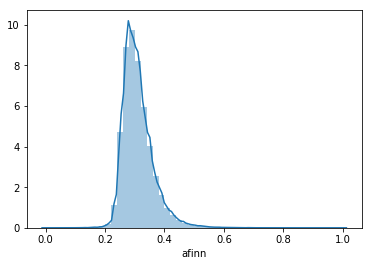

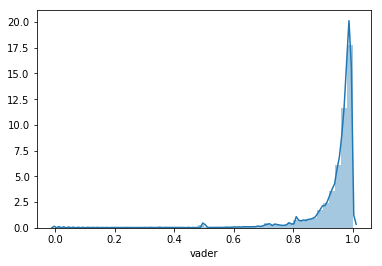

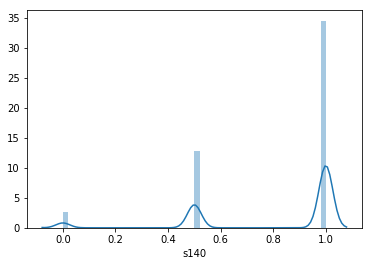

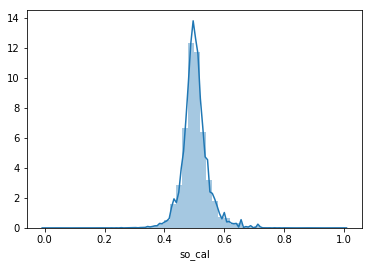

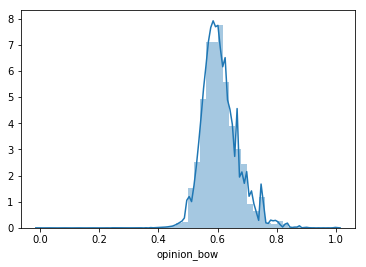

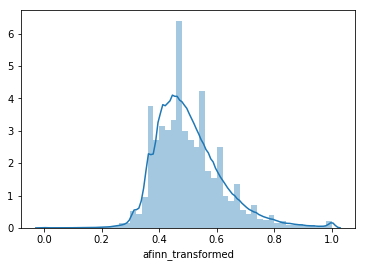

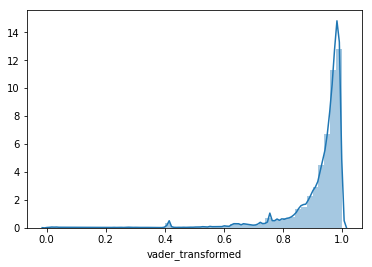

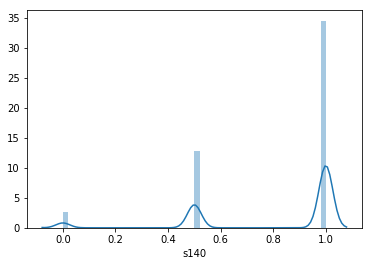

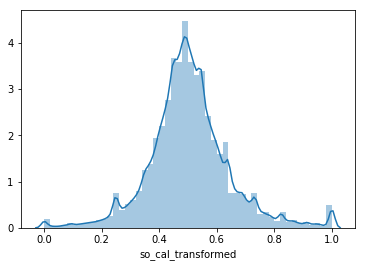

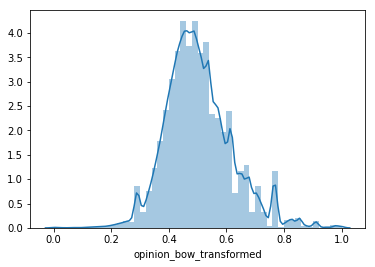

In [1225]:
whole_score_table, whole_tools = perform_analysis(reviews, whole_tool_settings)

In [992]:
whole_score_table[whole_score_table['vader_transformed'] < 0.2]

,id,comments,afinn,vader,s140,so_cal,opinion_bow,afinn_transformed,vader_transformed,so_cal_transformed,opinion_bow_transformed
232,6236,Dead cockroaches. Cat hair everywhere. Not very clean.,0.225166,0.110120,0.0,0.330000,0.500000,0.295880,0.079318,0.000000,0.290349
375,29344,"The apartment is not the place shown in the pictures, it was not clean, never met Akiko only her friend (Website hidden by Airbnb) unfortunetly I have nothing positive to say about my stay. Sorry, but I feel cheated!!",0.238411,0.113377,0.0,0.378571,0.500000,0.329583,0.081757,0.068230,0.290349
481,2295972,"We've already stayed five times with airbnb and this was definitely the worst! The bedroom smells, the bed and the pillows are horribly uncomfortable, it's loud. The bathroom is a bit dirty, it smells of mildew and on the shower curtain there is a lot of mildew!! The host let you feel unwanted,he doesn't want you to use the kitchen and isn't helpful at all. The location isn't bad for that money, but if you can afford more don't stay here.",0.172185,0.123948,0.0,0.289286,0.428571,0.157321,0.089713,0.000000,0.139600
561,20676723,This place is horrible and not what is represented in the photos. Not to mention very dirty. I had a horrible experience!,0.178808,0.054259,0.0,0.234286,0.357143,0.174979,0.038325,0.000000,0.000000
587,31027432,He is very quiet but gave no idea about the area The room was a bit small and the walls and windows are dirty as was the microwave. We could not use the kitchen sink as it was blocked . Good location Dave,0.225166,0.165932,0.0,0.366857,0.500000,0.295880,0.121890,0.024927,0.290349
606,41269884,"Our apartment building in Philadelphia caught fire, and much of our possessions were ruined and the whole building rendered uninhabitable by water damage the day before I had planned to stay with Shunichi. So I feel asleep within an hour after arriving at his apartment and didn't wake up until the next morning. Which goes to show that the room faces a quiet street and that the bed is comfortable, even if a metal frame. The room is as it looks in the photo, with the additions of a table cloth, cups, mugs and a small mirror, without the plant, stool and dark full length curtain, now replaced by a shorter one that lets the light through it. Shunichi was very communicative about my move in and had no problem with me coming earlier than I initially indicated,nor with me leaving my luggage at his place until I left the city the following day. Then I crashed out.",0.178808,0.072395,0.0,0.395536,0.478873,0.174979,0.051461,0.130292,0.246522
2143,108810133,"DO NOT GO HERE! I wouldn't recommend this place to anyone because this place is NOT SAFE. We saw people on the stairs, exchanging marijuanas, buying and selling marijuanas. It's really not safe here, very noisy that you could hardly sleep. Whenever i call Doris on the phone, she wouldn't answer and I don't know why. It's sooooo dusty and dirty everywhere. As soon as you enter the premise, you will see garbages on the stairs, all the way up to the 4th floor. Someone also puked on the staird but no one bothered cleaning it. Sooo disgusting! When we entered the unit, it felt creepy, creaking floor, no lights. The room has no own keys so whenever we ho out, we had no choice but to put all our things inside our luggages for safety. But then again, the room is still open so there's no assurance as someone could get our luggages while we're out. You can't be at peace coz you'll be thinking of your belongings. When you're inside the room, the doorknob is also not good coz there's a possib...",0.172185,0.001503,0.0,0.307143,0.500000,0.157321,0.001042,0.000000,0.290349
3493,2616116,"Excellent location, there are nice restaurants and bars nearby. Not enough blankets, the climate was cold and she only had 2 blankets for 4 people. The apartment was full of things, there is no space to place things in the bathroom and only 4 hangers in the closet!!! You can unpack your clothe because there is no space t

In [993]:
whole_level3_table, whole_level3 = get_levels(whole_score_table, whole_tools, 3)
whole_level5_table, whole_level5 = get_levels(whole_score_table, whole_tools, 5)

,1,2,3
level3_afinn_transformed,10748,191281,23061
level3_vader_transformed,2948,6951,215191
level3_s140,12115,57538,155437
level3_so_cal_transformed,23260,175670,26160
level3_opinion_bow_transformed,13506,186711,24873


,1,2,3,4,5
level5_afinn_transformed,364.0,39617.0,142587.0,37357.0,5165.0
level5_vader_transformed,1759.0,1500.0,4001.0,16013.0,201817.0
level5_s140,12115.0,NaN,57538.0,NaN,155437.0
level5_so_cal_transformed,4284.0,36448.0,141084.0,35597.0,7677.0
level5_opinion_bow_transformed,659.0,35069.0,148132.0,37479.0,3751.0


,afinn_sent,vader_sent,s140_sent,so_cal_sent,opinion_bow_sent
count,1.092606e+06,1.092606e+06,1.092606e+06,1.092606e+06,1.092606e+06
mean,2.460503e+00,4.340535e-01,2.172761e+00,2.134028e+00,2.144399e-01
std,2.574946e+00,3.477410e-01,7.823156e-01,2.527060e+00,2.260525e-01
min,-2.100000e+01,-9.897000e-01,0.000000e+00,-3.000000e+01,-1.000000e+00
25%,0.000000e+00,1.910000e-02,2.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,5.106000e-01,2.000000e+00,2.000000e+00,2.000000e-01
75%,4.000000e+00,6.908000e-01,2.000000e+00,3.500000e+00,3.333333e-01
max,4.100000e+01,9.963000e-01,4.000000e+00,5.760000e+01,1.000000e+00


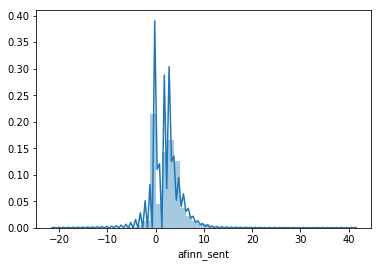

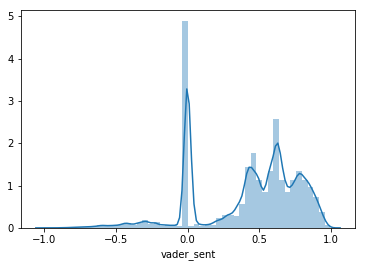

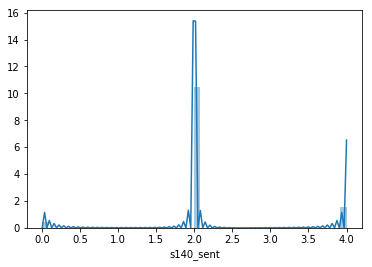

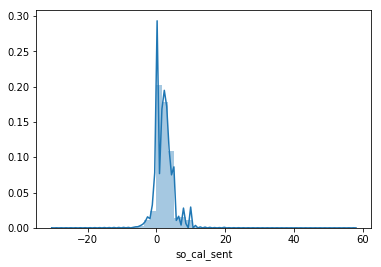

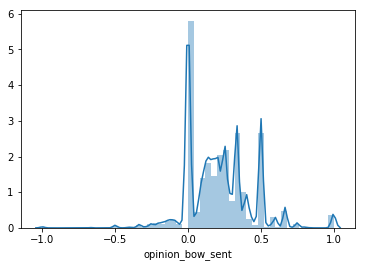

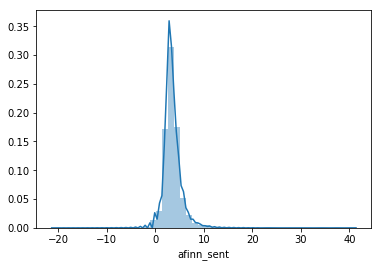

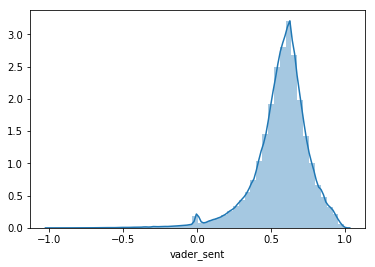

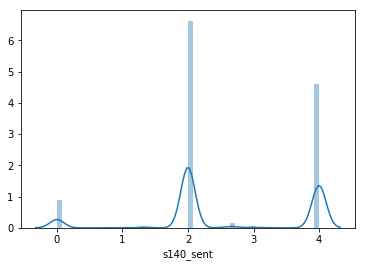

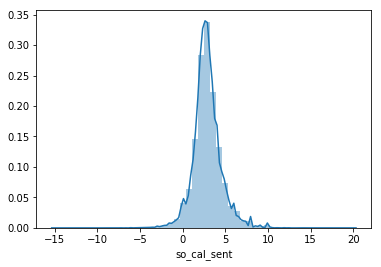

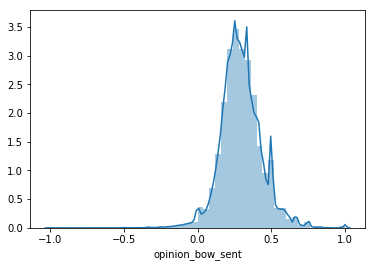

In [1226]:
# Sentences
sent_tools = list(sent_tool_settings.keys())
sent_score_table = reviews[['id', 'comments']+sent_tools]
sent_remove_vals = {'afinn_sent':0, 'vader_sent':0, 's140_sent':2, 'so_cal_sent':0, 'opinion_bow_sent':0}
all_sent_scores = flatten_sent_scores(sent_score_table, sent_tools)
display_html(all_sent_scores.describe())
plot_distributions(all_sent_scores, sent_tools)
sent_score_table = sent.reduce_to_scores(sent_score_table, sent_tools , sent_remove_vals, True)
plot_distributions(sent_score_table, sent_tools)


In [1227]:
sent_score_table[sent_tools] = sent_score_table[sent_tools].astype(float)

,afinn_sent,vader_sent,s140_sent,so_cal_sent,opinion_bow_sent
count,225090.000000,225090.000000,225090.000000,225090.000000,225090.000000
mean,3.521123,0.566211,2.601902,2.895892,0.296439
std,1.864159,0.187432,1.193184,1.648183,0.139739
min,-21.000000,-0.990000,0.000000,-15.000000,-1.000000
25%,2.500000,0.489000,2.000000,2.000000,0.211000
50%,3.250000,0.591000,2.000000,2.787000,0.288000
75%,4.250000,0.676000,4.000000,3.670000,0.375000
max,41.000000,0.996000,4.000000,20.000000,1.000000


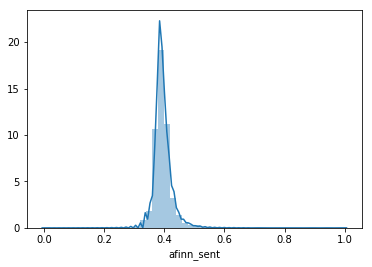

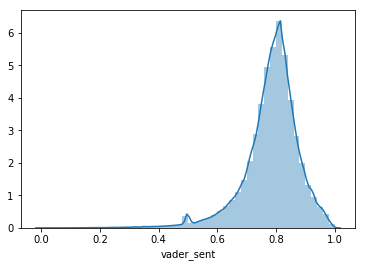

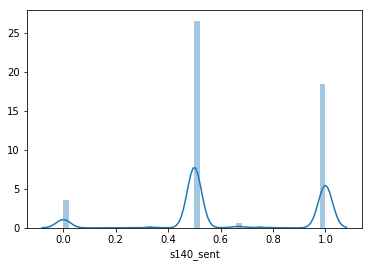

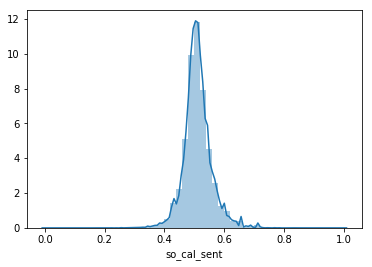

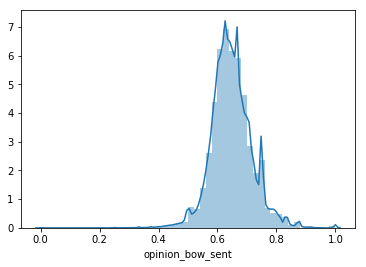

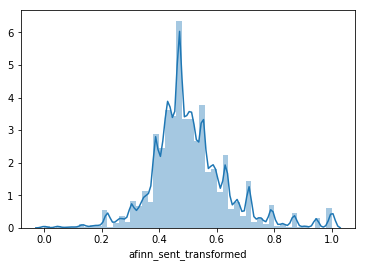

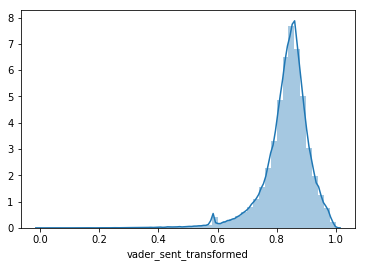

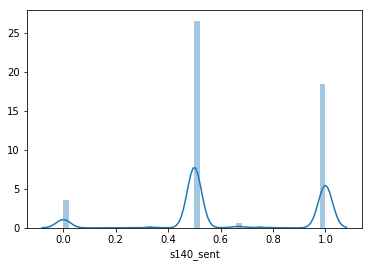

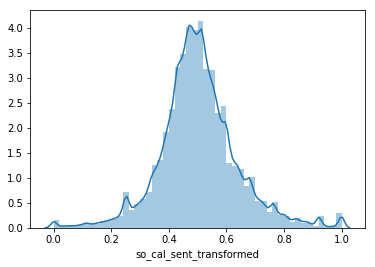

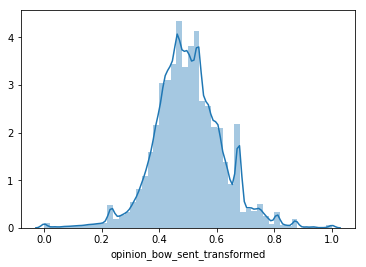

In [1228]:
sent_score_table, sent_tools = perform_analysis(sent_score_table, sent_tool_settings)

In [1229]:
sent_level3_table, sent_level3 = get_levels(sent_score_table, sent_tools, 3)
sent_level5_table, sent_level5 = get_levels(sent_score_table, sent_tools, 5)

,1,2,3
level3_afinn_sent_transformed,16966,180885,27239
level3_vader_sent_transformed,338,6991,217761
level3_s140_sent,18117,119792,87181
level3_so_cal_sent_transformed,21662,176968,26460
level3_opinion_bow_sent_transformed,16629,185117,23344


,1,2,3,4,5
level5_afinn_sent_transformed,2099,34075,146133,35244,7539
level5_vader_sent_transformed,60,511,4139,48871,171509
level5_s140_sent,16549,1715,119635,3888,83303
level5_so_cal_sent_transformed,3948,35028,144962,34778,6374
level5_opinion_bow_sent_transformed,2446,34158,146985,38203,3298


In [1230]:
interrater_reviews = pd.read_csv('interrater/interrater_uq2.csv', index_col=0)

In [1231]:
sent_level3_table[sent_level3_table['level3_afinn_sent_transformed'] == 1]

,id,comments,level3_afinn_sent_transformed,level3_vader_sent_transformed,level3_s140_sent,level3_so_cal_sent_transformed,level3_opinion_bow_sent_transformed
202,248421191,Robin’s place was great. Very spacious and we got the place to ourselves. Both her and her mom were very timely with responses when we had questions and let us leave our bags there after we checked out. The subway stop is a little far but still walkable. Overall we had a great stay!,1,3,2,2,2
232,6236,Dead cockroaches. Cat hair everywhere. Not very clean.,1,1,2,1,2
300,21854,"Adrienne was very helpful and informative for our stay. Unfortunately, illness got the best of us, and we were unable to make the trip but will definitely look for her place first when we reschedule our visit.",1,3,1,2,1
301,24023,"Although i was unable to make the stay due to an injury, addrienne was kind enough to give me a credit. I look forward to staying there in March.",1,3,1,1,1
304,61812,"Adrienne, I have just seen your review and it surprises me how can you be so accurate when you were never there or never met you. What do you mean the apartment was not well kept? It is true I made the next guest wait, for approximately 40 minutes if I recall and I apologized to him, and it was time I spent cleaning for him. What do you mean the guest did not fit through the hallway? This has to be figurative speech because he did fit and left his stuff in the room while he went to buy groceries during that time. And again it wasn't late at night (6 or 7 P.M., the time the other guest was arriving doesn't constitute late at night, at least for the standards in my country). As it says below, you have to state the facts or at least get them right. I hope you got rid of the ant infection in the bathroom and kitchen, because it was very annoying. Apart from that everything was OK!",1,3,1,1,1
324,1076344,if you want someone bothering you about using too many towels then stay here .,1,2,2,1,1
328,7073479,Adrienne's apt was perfect for my NY trip. Her place is conveniently located and the atmosphere of her home is cozy and relaxing. She communicated with me clearly and worked hard to get me the keys when there were last minute conflicts with our travel plans.,1,3,1,2,2
342,78406178,"We felt very welcome, she had it cleaned and instructions for anything that might go wrong available to us.",1,2,2,2,1
375,29344,"The apartment is not the place shown in the pictures, it was not clean, never met Akiko only her friend (Website hidden by Airbnb) unfortunetly I have nothing positive to say about my stay. Sorry, but I feel cheated!!",1,1,1,1,1
402,164743,"We would stay here again with Shun. Perfect location for NYC, easy to get around on foot and subway (5min walk to closest subway). 24hr conveient store downstairs, bottle shop, pharmacy not far. Shun was very quiet and kept to himself. For what you pay, I couldn't ask for anything else. Our plane was delayed because of the blizzard and didn't arrive till late at night. He let us in and made us a coffee!",1,3,1,1,1


In [1232]:
len(interrater_reviews)

70

In [1233]:
interrater_reviews['interrater_weighted_avg'] = utils.minmaxscale(interrater_reviews['interrater_weighted_avg'])

In [1234]:
voters3_table = sent_level3_table[['id', 'comments'] + sent_level3].join(whole_levels3_table[['id'] + whole_level3].set_index('id'), on='id')
voters3_tools = sent_level3+whole_level3

In [1235]:
len(interrater_reviews)

70

In [1236]:
voters5_table = sent_level5_table[['id', 'comments'] + sent_level5].join(whole_levels5_table[['id'] + whole_level5].set_index('id'), on='id')
voters5_tools = sent_level5+whole_level5

In [1237]:
test3 = analysis.split_into_levels(interrater_reviews, interrater_reviews, 'interrater_weighted_avg', type=2)
test5 = analysis.split_into_levels(interrater_reviews, interrater_reviews, 'interrater_weighted_avg', type=1)

In [1238]:
def show_evaluation(reviews, test, voters_table, voters_tools, level):
    print(test.columns)
    test["level"+str(level)+"_interrater_weighted_avg"].value_counts()
    test = reviews[['id', "level"+str(level)+"_interrater_weighted_avg"]].join(voters_table.set_index('id'), on='id')
    test = test.dropna()
    print(len(test))
    display_html(analysis.plot_confusion_matrix_grid(test, 'level'+str(level)+ "_interrater_weighted_avg", voters_tools))

Index(['idReview', 'id', 'date', 'reviewer_id', 'listing_id', 'recipient_id',
       'comments', 'interrater_weighted_avg', 'num_of_raters', 'len',
       'num_of_sents', 'level3_interrater_weighted_avg',
       'level5_interrater_weighted_avg'],
      dtype='object')
52
level3_afinn_sent_transformed


,Label,Gold,Guess,Precision,Recall,F1
0,1,14,14,0.857143,0.857143,0.857143
1,2,8,32,0.156250,0.625000,0.250000
2,3,30,6,0.666667,0.133333,0.222222
3,[All],52,52,0.403846,0.403846,0.403846


level3_vader_sent_transformed


,Label,Gold,Guess,Precision,Recall,F1
0,1,14,2,1.000000,0.142857,0.250000
1,2,8,9,0.222222,0.250000,0.235294
2,3,30,41,0.731707,1.000000,0.845070
3,[All],52,52,0.653846,0.653846,0.653846


level3_s140_sent


,Label,Gold,Guess,Precision,Recall,F1
0,1,14,15,0.466667,0.500000,0.482759
1,2,8,16,0.125000,0.250000,0.166667
2,3,30,21,0.666667,0.466667,0.549020
3,[All],52,52,0.442308,0.442308,0.442308


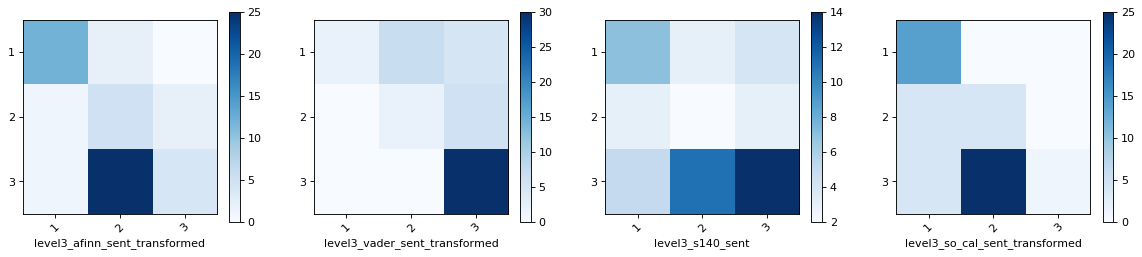

level3_so_cal_sent_transformed


,Label,Gold,Guess,Precision,Recall,F1
0,1,14,22,0.636364,1.000000,0.777778
1,2,8,29,0.137931,0.500000,0.216216
2,3,30,1,1.000000,0.033333,0.064516
3,[All],52,52,0.365385,0.365385,0.365385


level3_opinion_bow_sent_transformed


,Label,Gold,Guess,Precision,Recall,F1
0,1,14,17,0.764706,0.928571,0.838710
1,2,8,35,0.114286,0.500000,0.186047
2,3,30,0,0.000000,0.000000,0.000000
3,[All],52,52,0.326923,0.326923,0.326923


level3_afinn_transformed


,Label,Gold,Guess,Precision,Recall,F1
0,1,14,6,0.833333,0.357143,0.500000
1,2,8,31,0.161290,0.625000,0.256410
2,3,30,15,0.800000,0.400000,0.533333
3,[All],52,52,0.423077,0.423077,0.423077


level3_vader_transformed


,Label,Gold,Guess,Precision,Recall,F1
0,1,14,10,0.80,0.571429,0.666667
1,2,8,2,0.50,0.125000,0.200000
2,3,30,40,0.75,1.000000,0.857143
3,[All],52,52,0.75,0.750000,0.750000


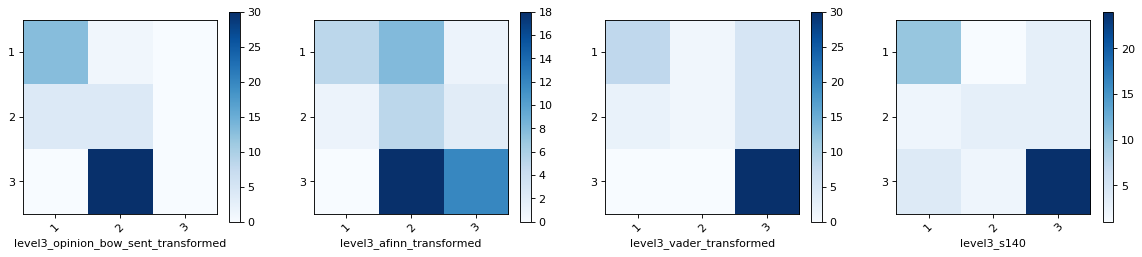

level3_s140


,Label,Gold,Guess,Precision,Recall,F1
0,1,14,16,0.625000,0.714286,0.666667
1,2,8,6,0.500000,0.375000,0.428571
2,3,30,30,0.800000,0.800000,0.800000
3,[All],52,52,0.711538,0.711538,0.711538


level3_so_cal_transformed


,Label,Gold,Guess,Precision,Recall,F1
0,1,14,23,0.608696,1.000000,0.756757
1,2,8,27,0.111111,0.375000,0.171429
2,3,30,2,1.000000,0.066667,0.125000
3,[All],52,52,0.365385,0.365385,0.365385


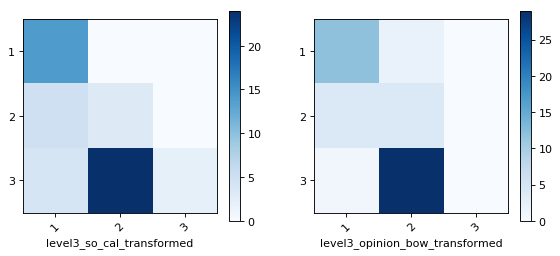

level3_opinion_bow_transformed


,Label,Gold,Guess,Precision,Recall,F1
0,1,14,17,0.705882,0.857143,0.774194
1,2,8,35,0.114286,0.500000,0.186047
2,3,30,0,0.000000,0.000000,0.000000
3,[All],52,52,0.307692,0.307692,0.307692


In [1239]:
show_evaluation(interrater_reviews, test3, voters3_table, voters3_tools, 3)

Index(['idReview', 'id', 'date', 'reviewer_id', 'listing_id', 'recipient_id',
       'comments', 'interrater_weighted_avg', 'num_of_raters', 'len',
       'num_of_sents', 'level3_interrater_weighted_avg',
       'level5_interrater_weighted_avg'],
      dtype='object')
52
level5_afinn_sent_transformed


,Label,Gold,Guess,Precision,Recall,F1
0,1,8,4,0.500000,0.250000,0.333333
1,2,6,21,0.238095,0.833333,0.370370
2,3,6,20,0.100000,0.333333,0.153846
3,4,9,5,0.000000,0.000000,0.000000
4,5,23,2,0.500000,0.043478,0.080000
5,[All],52,52,0.192308,0.192308,0.192308


level5_vader_sent_transformed


,Label,Gold,Guess,Precision,Recall,F1
0,1,8,0,0.000000,0.000000,0.000000
1,2,6,2,0.500000,0.166667,0.250000
2,3,6,6,0.166667,0.166667,0.166667
3,4,9,20,0.300000,0.666667,0.413793
4,5,23,24,0.791667,0.826087,0.808511
5,[All],52,52,0.519231,0.519231,0.519231


level5_s140_sent


,Label,Gold,Guess,Precision,Recall,F1
0,1,8,13,0.384615,0.625000,0.476190
1,2,6,3,0.000000,0.000000,0.000000
2,3,6,15,0.066667,0.166667,0.095238
3,4,9,4,0.000000,0.000000,0.000000
4,5,23,17,0.647059,0.478261,0.550000
5,[All],52,52,0.326923,0.326923,0.326923


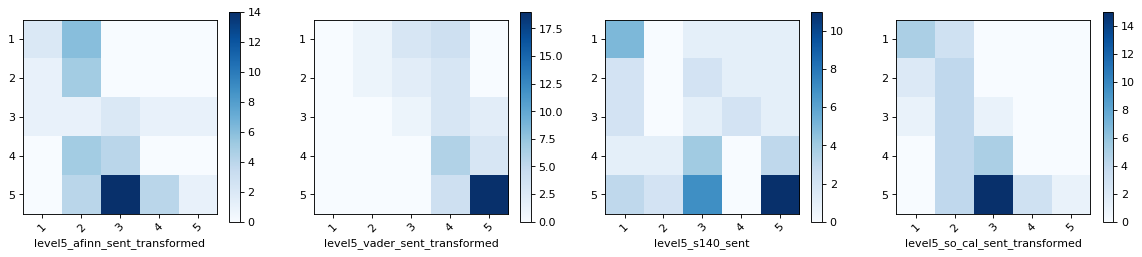

level5_so_cal_sent_transformed


,Label,Gold,Guess,Precision,Recall,F1
0,1,8,8,0.625000,0.625000,0.625000
1,2,6,19,0.210526,0.666667,0.320000
2,3,6,21,0.047619,0.166667,0.074074
3,4,9,3,0.000000,0.000000,0.000000
4,5,23,1,1.000000,0.043478,0.083333
5,[All],52,52,0.211538,0.211538,0.211538


level5_opinion_bow_sent_transformed


,Label,Gold,Guess,Precision,Recall,F1
0,1,8,8,0.500000,0.500000,0.500000
1,2,6,20,0.100000,0.333333,0.153846
2,3,6,24,0.125000,0.500000,0.200000
3,4,9,0,0.000000,0.000000,0.000000
4,5,23,0,0.000000,0.000000,0.000000
5,[All],52,52,0.173077,0.173077,0.173077


level5_afinn_transformed


,Label,Gold,Guess,Precision,Recall,F1
0,1,8,1,0.000000,0.000000,0.000000
1,2,6,10,0.300000,0.500000,0.375000
2,3,6,21,0.142857,0.500000,0.222222
3,4,9,12,0.166667,0.222222,0.190476
4,5,23,8,0.500000,0.173913,0.258065
5,[All],52,52,0.230769,0.230769,0.230769


level5_vader_transformed


,Label,Gold,Guess,Precision,Recall,F1
0,1,8,9,0.444444,0.500000,0.470588
1,2,6,1,0.000000,0.000000,0.000000
2,3,6,2,0.500000,0.166667,0.250000
3,4,9,1,0.000000,0.000000,0.000000
4,5,23,39,0.589744,1.000000,0.741935
5,[All],52,52,0.538462,0.538462,0.538462


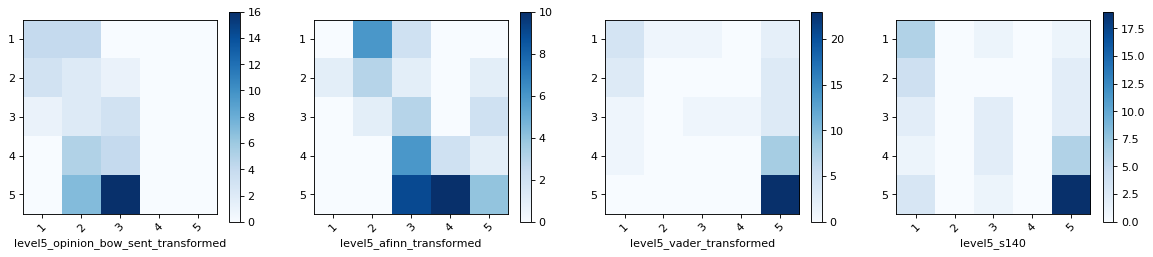

level5_s140


,Label,Gold,Guess,Precision,Recall,F1
0,1,8,16,0.375000,0.750000,0.500000
1,2,6,0,0.000000,0.000000,0.000000
2,3,6,6,0.333333,0.333333,0.333333
3,4,9,0,0.000000,0.000000,0.000000
4,5,23,30,0.633333,0.826087,0.716981
5,[All],52,52,0.519231,0.519231,0.519231


level5_so_cal_transformed


,Label,Gold,Guess,Precision,Recall,F1
0,1,8,11,0.363636,0.500000,0.421053
1,2,6,15,0.066667,0.166667,0.095238
2,3,6,24,0.041667,0.166667,0.066667
3,4,9,2,0.000000,0.000000,0.000000
4,5,23,0,0.000000,0.000000,0.000000
5,[All],52,52,0.115385,0.115385,0.115385


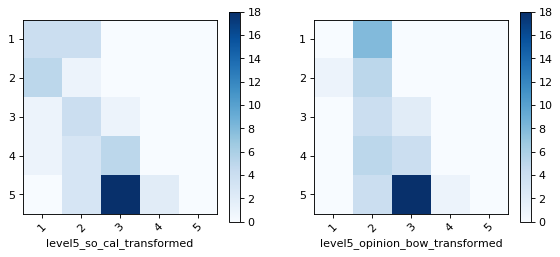

level5_opinion_bow_transformed


,Label,Gold,Guess,Precision,Recall,F1
0,1,8,1,0.000000,0.000000,0.000000
1,2,6,26,0.192308,0.833333,0.312500
2,3,6,24,0.083333,0.333333,0.133333
3,4,9,1,0.000000,0.000000,0.000000
4,5,23,0,0.000000,0.000000,0.000000
5,[All],52,52,0.134615,0.134615,0.134615


In [1241]:
show_evaluation(interrater_reviews, test5, voters5_table, voters5_tools, 5)

In [1242]:
combined_voters = [v.replace("level3_", "") for v in sent_tools + whole_tools]

In [1243]:
combined = sent_score_table[['id', 'comments'] + sent_tools].join(whole_score_table[['id'] + whole_tools].set_index('id'), on='id')

In [1293]:
mix_voters = ['afinn_transformed', 'vader_sent_transformed', 's140', 'so_cal_sent_transformed']

In [1294]:
combined['mixed_score'] = np.average(combined[mix_voters], axis = 1)
combined.is_copy = False

In [1295]:
combined.head(10)

,id,comments,afinn_sent_transformed,vader_sent_transformed,s140_sent,so_cal_sent_transformed,opinion_bow_sent_transformed,afinn_transformed,vader_transformed,s140,so_cal_transformed,opinion_bow_transformed,mixed_score,level5_mixed_score,level3_mixed_score
202,248421191,Robin’s place was great. Very spacious and we got the place to ourselves. Both her and her mom were very timely with responses when we had questions and let us leave our bags there after we checked out. The subway stop is a little far but still walkable. Overall we had a great stay!,0.303776,0.708797,0.5,0.560469,0.487796,0.395921,0.886460,0.5,0.519737,0.427694,0.541297,3,2
204,234213,"We had the best possible time in NYC and Russell's apartment played a huge role in that. The location was perfect, the rooftop was incredible, and Russell was a brilliant host. Better than we could have hoped for. He was incredibly helpful and fun at the same time. The apartment itself was a great experience. So many fun things to look at. Beds were great too! I have a feeling I will be contacting him again when we return :) It was a really wonderful way to experience NYC",0.591602,0.895709,0.5,0.585889,0.553528,0.867344,0.995837,1.0,0.574013,0.579321,0.837235,4,3
205,264416,"Three of us stayed at this place for a week- it was amazing, clean, stylish, perfect location. Host was great. The rooftop patio really made the stay complete- overlooked downtown. I would recommend this place to any group of 2 or 3 people!",0.490151,0.797149,1.0,0.478958,0.548393,0.524529,0.966939,1.0,0.524133,0.519324,0.700159,4,2
206,843520,A great apartment in the perfect location. I would stay here again if I am ever back in New York.,0.711449,0.939168,0.5,0.640784,0.675726,0.412289,0.886656,0.5,0.686310,0.489757,0.623060,4,3
207,993034,Russ is an amazing host and his awesome apartment is located in a neighborhood with multiple dining options. It is close to all the touristy attractions BUT not too close. The rooftop has a great view. We were in Soho in 5-10 minutes or Brooklyn in 20-30 minutes via the subway lines. Russ took the time to come over and personally attend to our needs when we required some internet assistance.,0.578133,0.833068,1.0,0.461046,0.478156,0.524529,0.938728,1.0,0.480458,0.377390,0.704661,4,2
208,1119849,"The apartment was really nice, like in the pictures. It is in a good location.",0.551197,0.837953,0.5,0.489002,0.634461,0.444770,0.885870,1.0,0.515887,0.702927,0.692931,3,2
213,4737934,"Russell was great to make his place become available with very short notice. Location was ideal for us. Although we never met in person the communication with Russell was great and he was quick to answer emails and assisting our enquiries. The apt is rather tight and would be recommended for 1-2 people. Interior creative and fun . On the downside a bit dusty, futon bed broken and uncomfortable and there is dog hair. Still overall a good experience.",0.387218,0.739578,0.0,0.394724,0.401651,0.508739,0.959916,1.0,0.348567,0.358258,0.660760,3,2
214,7269563,Awesome place! The best location and the apt. is great. I'll be staying here again for sure!,0.496933,0.838360,1.0,0.640784,0.765266,0.476918,0.962981,1.0,0.686310,0.615886,0.739015,4,3
215,19393799,"Pleasant apartment, good location and helpful owner - everything you need for a great weekend in New York",1.000000,0.972128,1.0,0.514656,0.535516,0.492869,0.945540,1.0,0.544691,0.615886,0.744913,4,3
216,31538251,"Russ is a really great guy and his place is both centrally located, cozy, and surprisingly spacious as far as NYC apartments can go. The decor is fun and homey, and it is walking distance from Times Square and all sorts of great theaters, restaurants and bars. Everything necessary was provided, and Russ went above and beyond to accommodate my needs as a guest- I would absolutely return.",0.671726,0.922784,1.0,0.477582,0.409754,0.492869,0.956244,1.0,0.514511,0.402716,0.723309,4,2


In [1296]:
combined = analysis.split_into_levels(combined, combined, 'mixed_score', 1)

In [1297]:
combined = analysis.split_into_levels(combined, combined, 'mixed_score', 2)

Index(['idReview', 'id', 'date', 'reviewer_id', 'listing_id', 'recipient_id',
       'comments', 'interrater_weighted_avg', 'num_of_raters', 'len',
       'num_of_sents', 'level3_interrater_weighted_avg',
       'level5_interrater_weighted_avg'],
      dtype='object')
52


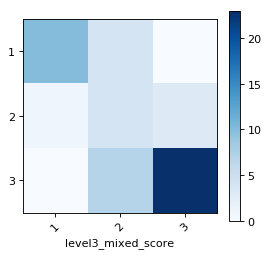

level3_mixed_score


,Label,Gold,Guess,Precision,Recall,F1
0,1,14,11,0.909091,0.714286,0.800000
1,2,8,15,0.266667,0.500000,0.347826
2,3,30,26,0.884615,0.766667,0.821429
3,[All],52,52,0.711538,0.711538,0.711538


In [1298]:
show_evaluation(interrater_reviews, test3, combined, ['level3_mixed_score'], 3)

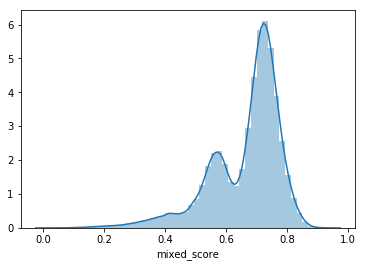

In [1308]:
sns.distplot(combined.mixed_score)
plt.show()

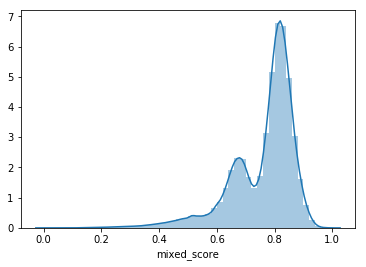

In [1307]:
sns.distplot(utils.minmaxscale(np.log(combined.mixed_score+ 1)))
plt.show()

In [1309]:
combined['norm'] = utils.minmaxscale(np.log(combined.mixed_score+ 1))

In [1312]:
combined.to_csv('final_sat.csv')

In [1311]:
combined[combined.norm <0.2]

,id,comments,afinn_sent_transformed,vader_sent_transformed,s140_sent,so_cal_sent_transformed,opinion_bow_sent_transformed,afinn_transformed,vader_transformed,s140,so_cal_transformed,opinion_bow_transformed,mixed_score,level5_mixed_score,level3_mixed_score,norm
481,2295972,"We've already stayed five times with airbnb and this was definitely the worst! The bedroom smells, the bed and the pillows are horribly uncomfortable, it's loud. The bathroom is a bit dirty, it smells of mildew and on the shower curtain there is a lot of mildew!! The host let you feel unwanted,he doesn't want you to use the kitchen and isn't helpful at all. The location isn't bad for that money, but if you can afford more don't stay here.",0.064743,0.397497,0.50000,0.000000,0.000000,0.157321,0.089713,0.0,0.000000,0.139600,0.138704,1,1,0.187454
561,20676723,This place is horrible and not what is represented in the photos. Not to mention very dirty. I had a horrible experience!,0.000000,0.294649,0.00000,0.000000,0.000000,0.174979,0.038325,0.0,0.000000,0.000000,0.117407,1,1,0.158783
2143,108810133,"DO NOT GO HERE! I wouldn't recommend this place to anyone because this place is NOT SAFE. We saw people on the stairs, exchanging marijuanas, buying and selling marijuanas. It's really not safe here, very noisy that you could hardly sleep. Whenever i call Doris on the phone, she wouldn't answer and I don't know why. It's sooooo dusty and dirty everywhere. As soon as you enter the premise, you will see garbages on the stairs, all the way up to the 4th floor. Someone also puked on the staird but no one bothered cleaning it. Sooo disgusting! When we entered the unit, it felt creepy, creaking floor, no lights. The room has no own keys so whenever we ho out, we had no choice but to put all our things inside our luggages for safety. But then again, the room is still open so there's no assurance as someone could get our luggages while we're out. You can't be at peace coz you'll be thinking of your belongings. When you're inside the room, the doorknob is also not good coz there's a possib...",0.164499,0.407937,0.00000,0.000000,0.168866,0.157321,0.001042,0.0,0.000000,0.290349,0.141315,1,1,0.190931
11858,124848757,"The location is great but the apartment was very disappointing : too noisy cause the window was not sealed (except with a piece of plastic stuffed there), too hot (you can not lower the heater in the apartment so it was 82°F inside), there are no curtains in one of the bedroom, and the ones in the other are not opaque (just thin white curtains), the common areas are very poorly maintained.",0.000000,0.179418,0.00000,0.029586,0.200954,0.261810,0.097994,0.0,0.000072,0.254629,0.117703,1,1,0.159186
14289,11537537,"The apartment is located in a ragged building and it, itself, presents a deterioration that does not appear at all in the advertisement: dirties floors and windows, worn-out bed linen, poor mattress, bad frying pans, etc.. Nevertheless the main problem of it is the hot: the kitchen, restroom and a room do not have heating but a pipe goes through the wall from top to bottom to the upper stores making sometimes the heat unbearable which only can be remedied opening the windows even at midnight. Even worse is the situation in the main room, the only that counts on a radiator as this does not work but where, in spite of that, the hot water gets out to the room as water vapour through the stopcock making a noise similar to out of a device for spraying when functioning. To sum up, even if the kitchen and the shoer are correct, the apartment is not worth at all what it cost.",0.000000,0.373586,0.00000,0.077649,0.217344,0.103741,0.023789,0.0,0.029657,0.207509,0.138744,1,1,0.187506
19859,444686,Terrible stay. Dirty apartment. Host did nothing to help when the front door knob fell off. Shower was moldy and disgusting.,0.090745,0.353826,0.00000,0.000000,0.000000,0.210001,0.036776,0.0,0.000000,0.000000,0.140957,1,1,0.190455
30367,6992543,"Everything breaks in this apartme

Index(['idReview', 'id', 'date', 'reviewer_id', 'listing_id', 'recipient_id',
       'comments', 'interrater_weighted_avg', 'num_of_raters', 'len',
       'num_of_sents', 'level3_interrater_weighted_avg',
       'level5_interrater_weighted_avg'],
      dtype='object')
52


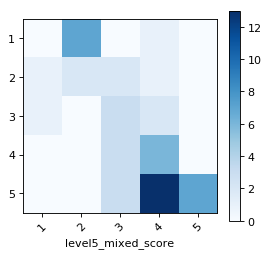

level5_mixed_score


,Label,Gold,Guess,Precision,Recall,F1
0,1,8,2,0.000000,0.000000,0.000000
1,2,6,9,0.222222,0.333333,0.266667
2,3,6,11,0.272727,0.500000,0.352941
3,4,9,23,0.260870,0.666667,0.375000
4,5,23,7,1.000000,0.304348,0.466667
5,[All],52,52,0.346154,0.346154,0.346154


In [1301]:
show_evaluation(interrater_reviews, test5, combined, ['level5_mixed_score'], 5)

In [1273]:
# Majority vote 

In [1274]:
voters_sent_level3 = ["level3_"+t for t in sent_tools]
voters_sent_level5 = ["level5_"+t for t in sent_tools]

In [1275]:
majority_vote_sent3 = majority_vote(sent_level3_table, voters_sent_level3)

In [1276]:
majority_vote_sent3[majority_vote_sent3.vote == 1]

,id,comments,level3_afinn_sent_transformed,level3_vader_sent_transformed,level3_s140_sent,level3_so_cal_sent_transformed,level3_opinion_bow_sent_transformed,vote
232,6236,Dead cockroaches. Cat hair everywhere. Not very clean.,1,1,2,1,2,1.0
301,24023,"Although i was unable to make the stay due to an injury, addrienne was kind enough to give me a credit. I look forward to staying there in March.",1,3,1,1,1,1.0
304,61812,"Adrienne, I have just seen your review and it surprises me how can you be so accurate when you were never there or never met you. What do you mean the apartment was not well kept? It is true I made the next guest wait, for approximately 40 minutes if I recall and I apologized to him, and it was time I spent cleaning for him. What do you mean the guest did not fit through the hallway? This has to be figurative speech because he did fit and left his stuff in the room while he went to buy groceries during that time. And again it wasn't late at night (6 or 7 P.M., the time the other guest was arriving doesn't constitute late at night, at least for the standards in my country). As it says below, you have to state the facts or at least get them right. I hope you got rid of the ant infection in the bathroom and kitchen, because it was very annoying. Apart from that everything was OK!",1,3,1,1,1,1.0
324,1076344,if you want someone bothering you about using too many towels then stay here .,1,2,2,1,1,1.0
375,29344,"The apartment is not the place shown in the pictures, it was not clean, never met Akiko only her friend (Website hidden by Airbnb) unfortunetly I have nothing positive to say about my stay. Sorry, but I feel cheated!!",1,1,1,1,1,1.0
402,164743,"We would stay here again with Shun. Perfect location for NYC, easy to get around on foot and subway (5min walk to closest subway). 24hr conveient store downstairs, bottle shop, pharmacy not far. Shun was very quiet and kept to himself. For what you pay, I couldn't ask for anything else. Our plane was delayed because of the blizzard and didn't arrive till late at night. He let us in and made us a coffee!",1,3,1,1,1,1.0
468,1260860,"I arrived right around the time that I arranged with Shun to be there. Shun came down to the door and let me in. Perhaps he did this in order to lead me directly to the apartment the first time, as I might conceivably have gotten confused as to where the apartment is, due to the stairway and apartment layout. Anyway, first appearances of the building might be scary for some. It is rather run down. Indeed, the apartment must not have enough storage space because there are boxes lining the hallway leading to the main part of the apartment. The room is very basic, but is as advertised. There is a small refrigerator, some dishes and a microwave, a TV and WiFi. The apartment could use a cosmetic facelift, for sure, but apart from that, it was comfortable enough, though spartan. After introductions, I didn't see Shun again until shortly before I left. All in all, though I wouldn't necessarily recommend this for everyone, I would definitely return due to the convenience of location. Shun ...",1,2,1,1,1,1.0
481,2295972,"We've already stayed five times with airbnb and this was definitely the worst! The bedroom smells, the bed and the pillows are horribly uncomfortable, it's loud. The bathroom is a bit dirty, it smells of mildew and on the shower curtain there is a lot of mildew!! The host let you feel unwanted,he doesn't want you to use the kitchen and isn't helpful at all. The location isn't bad for that money, but if you can afford more don't stay here.",1,2,2,1,1,1.0
496,3645817,"The room was as described. Very confortable and a lot of privacy. Shunichi was always helpfull and polite. The location is priceless, very close to subways, the central park and times square. It was a bit difficult to adjust the water, it was too cold or too hot, but not a big deal. There was plenty of space in the room for two people. The fridge and microwave turned out to 

In [1277]:
majority_vote_sent5 = majority_vote(sent_level5_table, voters_sent_level5)

In [1278]:
majority_vote_sent5[majority_vote_sent5.vote == 1]

,id,comments,level5_afinn_sent_transformed,level5_vader_sent_transformed,level5_s140_sent,level5_so_cal_sent_transformed,level5_opinion_bow_sent_transformed,vote
375,29344,"The apartment is not the place shown in the pictures, it was not clean, never met Akiko only her friend (Website hidden by Airbnb) unfortunetly I have nothing positive to say about my stay. Sorry, but I feel cheated!!",2,2,1,1,1,1.0
561,20676723,This place is horrible and not what is represented in the photos. Not to mention very dirty. I had a horrible experience!,1,2,1,1,1,1.0
2143,108810133,"DO NOT GO HERE! I wouldn't recommend this place to anyone because this place is NOT SAFE. We saw people on the stairs, exchanging marijuanas, buying and selling marijuanas. It's really not safe here, very noisy that you could hardly sleep. Whenever i call Doris on the phone, she wouldn't answer and I don't know why. It's sooooo dusty and dirty everywhere. As soon as you enter the premise, you will see garbages on the stairs, all the way up to the 4th floor. Someone also puked on the staird but no one bothered cleaning it. Sooo disgusting! When we entered the unit, it felt creepy, creaking floor, no lights. The room has no own keys so whenever we ho out, we had no choice but to put all our things inside our luggages for safety. But then again, the room is still open so there's no assurance as someone could get our luggages while we're out. You can't be at peace coz you'll be thinking of your belongings. When you're inside the room, the doorknob is also not good coz there's a possib...",1,3,1,1,1,1.0
6349,109051214,"You've got to read this listing REALLY carefully - both me and my friends failed to realize that it says ""1 room"" rather than ""1 bedroom"" - I don't know why Airbnb even has this as a listing option as it is really misleading. When we showed up and realized that 4 of us would be sleeping in a tiny living room together we were definitely disappointed (as we thought there was a bedroom). I'm shocked at how much we were charged for the 2 additional guests, given the size of the place. It's literally a living room and nothing else. Not even a kitchen sink. The apartment is in a great location, which is the main reason why we chose it - but in a building that has had very little upkeep. We saw a giant cockroach the size of our hand in the front entrance - made us a little nervous to keep our suitcases open. Jon, the host, was not there to greet us - I didn't realize he wouldn't be meeting us in person until he told me to buzz up to the cleaning lady. We had arranged a late checkout on o...",1,3,1,1,1,1.0
6849,3659104,"We found the apartment to be very small and uncomfortable to stay in. The bed was a double bed and the pillows provided were in extremely poor condition. Our stay was during a particular cold time in New York but the apartment was extremely hot (almost unpleasant), and it would be unbearable during spring/summer/fall. The bathroom is very cramped, shower is in poor working order as is the television which is an old box. Unless you are fit or youthful, the ascent up the flights of stairs in the apartment is very demanding on the legs and it almost feels like the stairs will collapse as it is a very old building. The East Village location is a little unsafe at night, better staying closer to Midtown/Grammercy where the action is.",1,3,1,1,1,1.0
10744,97014440,"24 check in as promised. I arrived at 9pm and Chris waited for us to hand-over the key. Although the unit is as the picture but the quality is poor. Thick dust almost everywhere. I needed to mop the floor. Dirty laundry are still in the basket. Wardrobe was full with owner stuff and messy. Portable Aircon only and it was very noisy - we need to turn it off since it disturbed our sleeping and when it got hot, need to turn in on - we did it several times during the night. We booked the apartment for four nights but we decided to move out one night after we stayed. No soap, no shampoo, no haird

Index(['idReview', 'id', 'date', 'reviewer_id', 'listing_id', 'recipient_id',
       'comments', 'interrater_weighted_avg', 'num_of_raters', 'len',
       'num_of_sents', 'level3_interrater_weighted_avg',
       'level5_interrater_weighted_avg'],
      dtype='object')
52


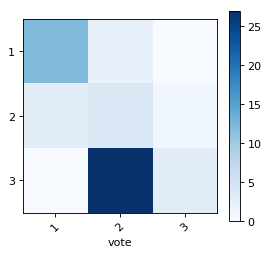

vote


,Label,Gold,Guess,Precision,Recall,F1
0,1,14,15,0.800000,0.857143,0.827586
1,2,8,33,0.121212,0.500000,0.195122
2,3,30,4,0.750000,0.100000,0.176471
3,[All],52,52,0.365385,0.365385,0.365385


In [1162]:
show_evaluation(interrater_reviews, test3, majority_vote_sent3, ['vote'], 3)

In [1163]:
voters_whole_level3 = ["level3_"+t for t in whole_tools]
voters_whole_level5 = ["level5_"+t for t in whole_tools]

In [1164]:
majority_vote_whole3 = majority_vote(whole_level3_table, voters_whole_level3)

In [1165]:
majority_vote_whole3[majority_vote_whole3.vote == 1]

,id,comments,level3_afinn_transformed,level3_vader_transformed,level3_s140,level3_so_cal_transformed,level3_opinion_bow_transformed,vote
232,6236,Dead cockroaches. Cat hair everywhere. Not very clean.,1,1,1,1,1,1.0
300,21854,"Adrienne was very helpful and informative for our stay. Unfortunately, illness got the best of us, and we were unable to make the trip but will definitely look for her place first when we reschedule our visit.",1,3,1,1,1,1.0
301,24023,"Although i was unable to make the stay due to an injury, addrienne was kind enough to give me a credit. I look forward to staying there in March.",1,3,1,1,1,1.0
304,61812,"Adrienne, I have just seen your review and it surprises me how can you be so accurate when you were never there or never met you. What do you mean the apartment was not well kept? It is true I made the next guest wait, for approximately 40 minutes if I recall and I apologized to him, and it was time I spent cleaning for him. What do you mean the guest did not fit through the hallway? This has to be figurative speech because he did fit and left his stuff in the room while he went to buy groceries during that time. And again it wasn't late at night (6 or 7 P.M., the time the other guest was arriving doesn't constitute late at night, at least for the standards in my country). As it says below, you have to state the facts or at least get them right. I hope you got rid of the ant infection in the bathroom and kitchen, because it was very annoying. Apart from that everything was OK!",1,3,1,1,1,1.0
324,1076344,if you want someone bothering you about using too many towels then stay here .,1,1,2,1,1,1.0
375,29344,"The apartment is not the place shown in the pictures, it was not clean, never met Akiko only her friend (Website hidden by Airbnb) unfortunetly I have nothing positive to say about my stay. Sorry, but I feel cheated!!",1,1,1,1,1,1.0
402,164743,"We would stay here again with Shun. Perfect location for NYC, easy to get around on foot and subway (5min walk to closest subway). 24hr conveient store downstairs, bottle shop, pharmacy not far. Shun was very quiet and kept to himself. For what you pay, I couldn't ask for anything else. Our plane was delayed because of the blizzard and didn't arrive till late at night. He let us in and made us a coffee!",1,3,1,1,1,1.0
481,2295972,"We've already stayed five times with airbnb and this was definitely the worst! The bedroom smells, the bed and the pillows are horribly uncomfortable, it's loud. The bathroom is a bit dirty, it smells of mildew and on the shower curtain there is a lot of mildew!! The host let you feel unwanted,he doesn't want you to use the kitchen and isn't helpful at all. The location isn't bad for that money, but if you can afford more don't stay here.",1,1,1,1,1,1.0
496,3645817,"The room was as described. Very confortable and a lot of privacy. Shunichi was always helpfull and polite. The location is priceless, very close to subways, the central park and times square. It was a bit difficult to adjust the water, it was too cold or too hot, but not a big deal. There was plenty of space in the room for two people. The fridge and microwave turned out to be really usefull. We will keep this in mind if going back to ny.",1,1,1,1,1,1.0
522,8945867,A very well-situated apartment several blocks away from Central Park,1,1,2,1,2,1.0


In [1166]:
majority_vote_sent5 = majority_vote(sent_level5_table, voters_sent_level5)

Index(['idReview', 'id', 'date', 'reviewer_id', 'listing_id', 'recipient_id',
       'comments', 'interrater_weighted_avg', 'num_of_raters', 'len',
       'num_of_sents', 'level3_interrater_weighted_avg',
       'level5_interrater_weighted_avg'],
      dtype='object')
52


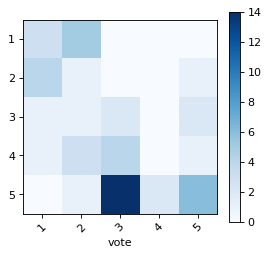

vote


,Label,Gold,Guess,Precision,Recall,F1
0,1,8,9,0.333333,0.375000,0.352941
1,2,6,11,0.090909,0.166667,0.117647
2,3,6,20,0.100000,0.333333,0.153846
3,4,9,2,0.000000,0.000000,0.000000
4,5,23,10,0.600000,0.260870,0.363636
5,[All],52,52,0.230769,0.230769,0.230769


In [1167]:
show_evaluation(interrater_reviews, test5, majority_vote_whole5, ['vote'], 5)

In [1168]:
combined_voters3 = ["level3_"+t for t in combined_voters]
combined_voters5 = ["level5_"+t for t in combined_voters]

In [1176]:
combined.head(10)

,id,comments,afinn_sent_transformed,vader_sent_transformed,s140_sent,so_cal_sent_transformed,opinion_bow_sent_transformed,afinn_transformed,vader_transformed,s140,so_cal_transformed,opinion_bow_transformed,mixed_score,level5_mixed_score,level3_mixed_score
202,248421191,Robin’s place was great. Very spacious and we got the place to ourselves. Both her and her mom were very timely with responses when we had questions and let us leave our bags there after we checked out. The subway stop is a little far but still walkable. Overall we had a great stay!,0.303776,0.314018,0.5,0.560469,0.487796,0.395921,0.886460,0.5,0.519737,0.427694,0.403313,3,2
204,234213,"We had the best possible time in NYC and Russell's apartment played a huge role in that. The location was perfect, the rooftop was incredible, and Russell was a brilliant host. Better than we could have hoped for. He was incredibly helpful and fun at the same time. The apartment itself was a great experience. So many fun things to look at. Beds were great too! I have a feeling I will be contacting him again when we return :) It was a really wonderful way to experience NYC",0.591602,0.754322,0.5,0.585889,0.553528,0.867344,0.995837,1.0,0.574013,0.579321,0.873889,5,3
205,264416,"Three of us stayed at this place for a week- it was amazing, clean, stylish, perfect location. Host was great. The rooftop patio really made the stay complete- overlooked downtown. I would recommend this place to any group of 2 or 3 people!",0.490151,0.522146,1.0,0.478958,0.548393,0.524529,0.966939,1.0,0.524133,0.519324,0.682225,4,3
206,843520,A great apartment in the perfect location. I would stay here again if I am ever back in New York.,0.711449,0.856698,0.5,0.640784,0.675726,0.412289,0.886656,0.5,0.686310,0.489757,0.589662,3,2
207,993034,Russ is an amazing host and his awesome apartment is located in a neighborhood with multiple dining options. It is close to all the touristy attractions BUT not too close. The rooftop has a great view. We were in Soho in 5-10 minutes or Brooklyn in 20-30 minutes via the subway lines. Russ took the time to come over and personally attend to our needs when we required some internet assistance.,0.578133,0.606761,1.0,0.461046,0.478156,0.524529,0.938728,1.0,0.480458,0.377390,0.710430,4,3
208,1119849,"The apartment was really nice, like in the pictures. It is in a good location.",0.551197,0.618269,0.5,0.489002,0.634461,0.444770,0.885870,1.0,0.515887,0.702927,0.687680,4,3
213,4737934,"Russell was great to make his place become available with very short notice. Location was ideal for us. Although we never met in person the communication with Russell was great and he was quick to answer emails and assisting our enquiries. The apt is rather tight and would be recommended for 1-2 people. Interior creative and fun . On the downside a bit dusty, futon bed broken and uncomfortable and there is dog hair. Still overall a good experience.",0.387218,0.386528,0.0,0.394724,0.401651,0.508739,0.959916,1.0,0.348567,0.358258,0.631756,4,2
214,7269563,Awesome place! The best location and the apt. is great. I'll be staying here again for sure!,0.496933,0.619226,1.0,0.640784,0.765266,0.476918,0.962981,1.0,0.686310,0.615886,0.698715,4,3
215,19393799,"Pleasant apartment, good location and helpful owner - everything you need for a great weekend in New York",1.000000,0.934342,1.0,0.514656,0.535516,0.492869,0.945540,1.0,0.544691,0.615886,0.809070,5,3
216,31538251,"Russ is a really great guy and his place is both centrally located, cozy, and surprisingly spacious as far as NYC apartments can go. The decor is fun and homey, and it is walking distance from Times Square and all sorts of great theaters, restaurants and bars. Everything necessary was provided, and Russ went above and beyond to accommodate my needs as a guest- I would absolutely return.",0.671726,0.818104,1.0,0.477582,0.409754,0.492869,0.956244,1.0,0.514511,0.402716,0.770324,4,3


In [1169]:
combined_table = combined.copy()

In [1170]:
combined_levels3_table, combine_level3 = get_levels(combined_table, mix_voters, 3)

,1,2,3
level3_afinn_transformed,10748,191281,23061
level3_vader_sent_transformed,17388,106018,101684
level3_s140,12115,57538,155437


In [1171]:
combined_levels5_table, combine_level5 = get_levels(combined_table, mix_voters, 5)

,1,2,3,4,5
level5_afinn_transformed,364.0,39617.0,142587.0,37357.0,5165.0
level5_vader_sent_transformed,8116.0,14915.0,65994.0,114191.0,21874.0
level5_s140,12115.0,NaN,57538.0,NaN,155437.0


In [1172]:
majority_vote_combined3 = majority_vote(combined_levels3_table, combine_level3)

Index(['idReview', 'id', 'date', 'reviewer_id', 'listing_id', 'recipient_id',
       'comments', 'interrater_weighted_avg', 'num_of_raters', 'len',
       'num_of_sents', 'level3_interrater_weighted_avg',
       'level5_interrater_weighted_avg'],
      dtype='object')
52


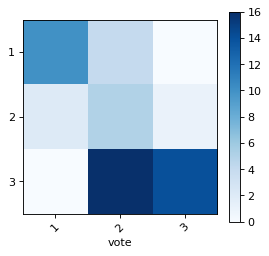

vote


,Label,Gold,Guess,Precision,Recall,F1
0,1,14,12,0.833333,0.714286,0.769231
1,2,8,25,0.200000,0.625000,0.303030
2,3,30,15,0.933333,0.466667,0.622222
3,[All],52,52,0.557692,0.557692,0.557692


In [1173]:
show_evaluation(interrater_reviews, test3, majority_vote_combined3, ['vote'], 3)

In [1174]:
majority_vote_combined5 = majority_vote(combined_levels5_table, combine_level5)

Index(['idReview', 'id', 'date', 'reviewer_id', 'listing_id', 'recipient_id',
       'comments', 'interrater_weighted_avg', 'num_of_raters', 'len',
       'num_of_sents', 'level3_interrater_weighted_avg',
       'level5_interrater_weighted_avg'],
      dtype='object')
52


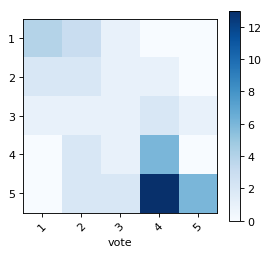

vote


,Label,Gold,Guess,Precision,Recall,F1
0,1,8,7,0.571429,0.500000,0.533333
1,2,6,10,0.200000,0.333333,0.250000
2,3,6,6,0.166667,0.166667,0.166667
3,4,9,22,0.272727,0.666667,0.387097
4,5,23,7,0.857143,0.260870,0.400000
5,[All],52,52,0.365385,0.365385,0.365385


In [1175]:
show_evaluation(interrater_reviews, test5, majority_vote_combined5, ['vote'], 5)

# Get Whole Averages +  convert into levels

Index(['idReview', 'id', 'date', 'reviewer_id', 'listing_id', 'recipient_id',
       'comments', 'interrater_weighted_avg', 'num_of_raters', 'len',
       'num_of_sents', 'level3_interrater_weighted_avg',
       'level5_interrater_weighted_avg'],
      dtype='object')
52


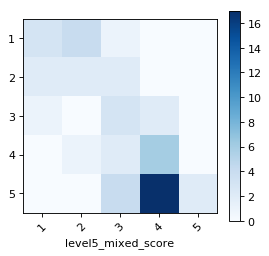

level5_mixed_score


,Label,Gold,Guess,Precision,Recall,F1
0,1,8,6,0.500000,0.375000,0.428571
1,2,6,7,0.285714,0.333333,0.307692
2,3,6,12,0.250000,0.500000,0.333333
3,4,9,25,0.240000,0.666667,0.352941
4,5,23,2,1.000000,0.086957,0.160000
5,[All],52,52,0.307692,0.307692,0.307692


In [653]:
show_evaluation(interrater_reviews, combined, ['level5_mixed_score'], 5)

## Score table

In [462]:
voters_whole = ['afinn_transformed_clipped', 'vader_transformed', 's140', 'so_cal_transformed_clipped', 'opinion_bow_transformed_clipped']
whole_scores = whole_score_table[['id', 'comments']+voters_whole]
whole_scores.is_copy = False

## Score averages

In [463]:
whole_scores['score_avg'] = np.average(whole_scores[voters_whole], axis=1)

In [464]:
whole_scores = analysis.split_into_levels(whole_scores, whole_scores, 'score_avg')
whole_scores = analysis.split_into_levels(whole_scores, whole_scores, 'score_avg', type=2)

## Majority Vote

In [467]:
majority_vote_whole3 = majority_vote(whole_levels3_table, voters_whole_level3)

In [468]:
voter_counts(whole_levels3_table, voters_whole_level3)

,level3_afinn_transformed_clipped,level3_opinion_bow_transformed_clipped,level3_s140,level3_so_cal_transformed_clipped,level3_vader_transformed,total
0,181970,175454,110311,177738,59721,225090


In [465]:
whole_levels3_table =analysis.build_levels_table(whole_scores, voters_whole, type=2)

In [466]:
voters_whole_level3 = [ "level3_"  + t for t in voters_whole] #'level_so_cal-norm',

In [471]:
majority_vote_whole5 = majority_vote(whole_levels5_table, voters_whole_level5)

In [472]:
voter_counts(whole_levels5_table, voters_whole_level5)

,level5_afinn_transformed_clipped,level5_opinion_bow_transformed_clipped,level5_s140,level5_so_cal_transformed_clipped,level5_vader_transformed,total
0,150969,164052,64688,170214,23701,225090


In [469]:
whole_levels5_table =analysis.build_levels_table(whole_scores, voters_whole)

In [470]:
voters_whole_level5 = [ "level5_"  + t for t in voters_whole] #'level_so_cal-norm',

# Sentiment by Sentence

In [475]:
def flatten_sent_scores(tbl, tools):
    new_tbl = pd.DataFrame()
    for t in tools:
        new_tbl[t] = [v for s in tbl[t] for v in eval(s)]
    return new_tbl

In [549]:
sent_score_table = normalise_tools_sent(sent_score_table, main_sent_tools)

TypeError: float() argument must be a string or a number, not 'list'

## Afinn

In [486]:
sent_score_table = utils.transform_tool_sent(sent_score_table, 'afinn_sent', 'log', 'inner')

TypeError: float() argument must be a string or a number, not 'list'

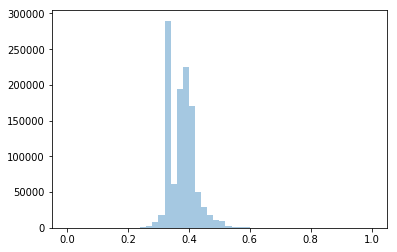

In [481]:
a = np.array([float(j) for i in sent_score_table['afinn_sent_transformed'] for j in i])
sns.distplot(a, kde=False)
plt.show()

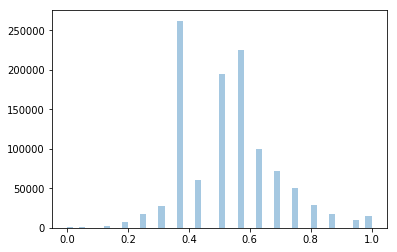

In [482]:
a = np.array([float(j) for i in sent_score_table['afinn_sent_transformed_clipped'] for j in i])
sns.distplot(a, kde=False)
plt.show()

# Vader Sentence

In [53]:
sent_score_table = utils.transform_tool_sent(sent_score_table, 'vader_sent', 'log', 'inner')

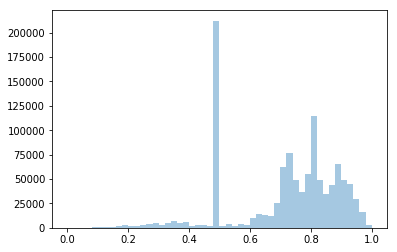

In [54]:
a = np.array([float(j) for i in sent_score_table['vader_sent_transformed'] for j in i])
sns.distplot(a, kde=False)
plt.show()

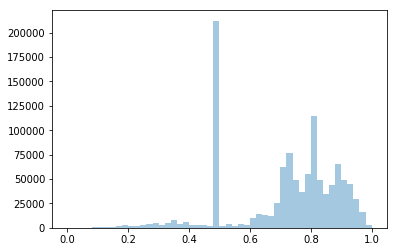

In [55]:
a = np.array([float(j) for i in sent_score_table['vader_sent_transformed_clipped'] for j in i])
sns.distplot(a, kde=False)
plt.show()

# S140 Sentence

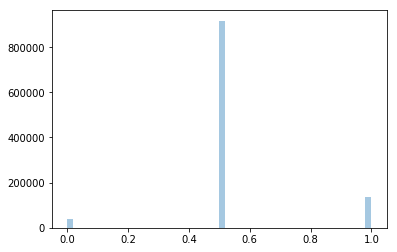

In [56]:
a = np.array([float(j) for i in sent_score_table['s140_sent'] for j in i])
sns.distplot(a, kde=False)
plt.show()

# SO_CAL Sentence

In [57]:
sent_score_table = utils.transform_tool_sent(sent_score_table, 'so_cal_sent', 'log', 'outer')

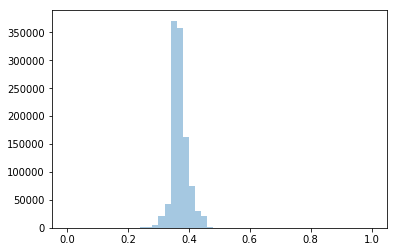

In [58]:
a = np.array([float(j) for i in sent_score_table['so_cal_sent_transformed'] for j in i])
sns.distplot(a, kde=False)
plt.show()

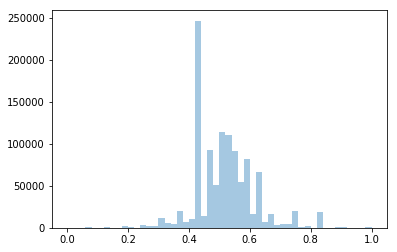

In [59]:
a = np.array([float(j) for i in sent_score_table['so_cal_sent_transformed_clipped'] for j in i])
sns.distplot(a, kde=False)
plt.show()

# Opinion-BOW Sentence

In [60]:
sent_score_table = utils.transform_tool_sent(sent_score_table, 'opinion_bow_sent', 'log', 'inner')

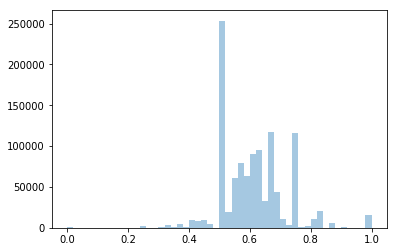

In [61]:
a = np.array([float(j) for i in sent_score_table['opinion_bow_sent_transformed'] for j in i])
sns.distplot(a, kde=False)
plt.show()

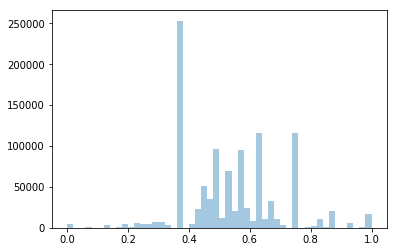

In [62]:
a = np.array([float(j) for i in sent_score_table['opinion_bow_sent_transformed_clipped'] for j in i])
sns.distplot(a, kde=False)
plt.show()

## Reduce and Show Distribution

In [63]:
voters_sent = ['afinn_sent_transformed_clipped', 'vader_sent_transformed', 's140_sent', 'so_cal_sent_transformed_clipped', 'opinion_bow_sent_transformed']

In [64]:
sent_scores = sent_score_table[['id', 'comments']+voters_sent]

In [65]:
sent_scores = sent.reduce_sentence_scores(sent_scores, voters_sent )

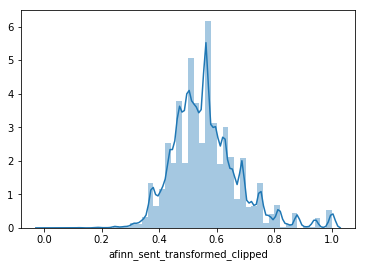

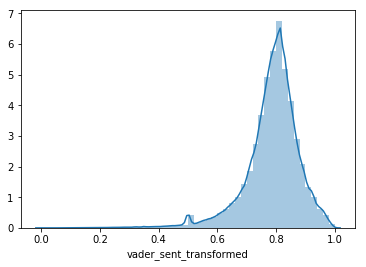

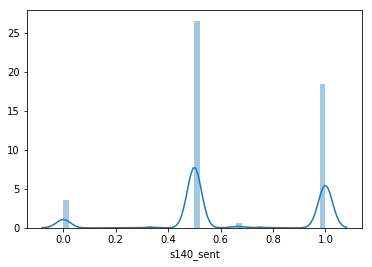

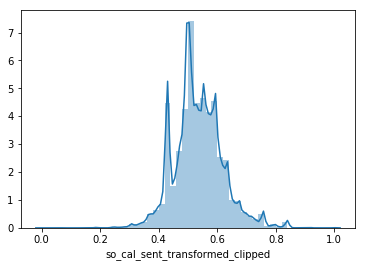

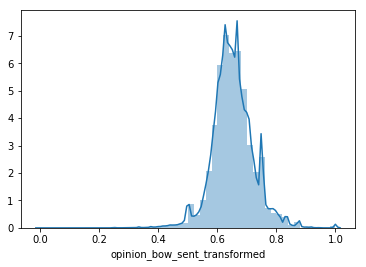

In [66]:
plot_distributions(sent_scores, voters_sent)

# Get Sent averages +  convert into levels

## Score averages

In [67]:
sent_scores['score_avg'] = np.average(sent_scores[voters_sent].astype(float), axis=1)

In [68]:
sent_scores = analysis.split_into_levels(sent_scores, sent_scores, 'score_avg')
sent_scores = analysis.split_into_levels(sent_scores, sent_scores, 'score_avg', type=2)

## Majority Vote

In [69]:
sent_levels3_table =analysis.build_levels_table(sent_scores, voters_sent, type=2)

In [144]:
voters_sent_level3 = [ "level3_"  + t for t in voters_sent] #'level_so_cal-norm',

In [71]:
majority_vote_sent3 = majority_vote(sent_levels3_table, voters_sent_level3)

In [72]:
voter_counts(sent_levels3_table, voters_sent_level3)

,level3_afinn_sent_transformed_clipped,level3_opinion_bow_sent_transformed,level3_s140_sent,level3_so_cal_sent_transformed_clipped,level3_vader_sent_transformed,total
0,187386,156293,159168,166499,84484,225090


In [73]:
sent_levels5_table =analysis.build_levels_table(sent_scores, voters_sent)

In [74]:
voters_sent_level5 = [ "level5_"  + t for t in voters_sent] #'level_so_cal-norm',

In [75]:
majority_vote_sent5 = majority_vote(sent_levels5_table, voters_sent_level5)

In [76]:
voter_counts(sent_levels5_table, voters_sent_level5)

,level5_afinn_sent_transformed_clipped,level5_opinion_bow_sent_transformed,level5_s140_sent,level5_so_cal_sent_transformed_clipped,level5_vader_sent_transformed,total
0,180619,95244,113151,178583,36659,225090


## Combine all voters and get majority vote

In [147]:
combined_voters3 = voters_sent_level3 + voters_whole_level3
combined_voters5 = voters_sent_level5 + voters_whole_level5

In [146]:
test_combined3 = sent_levels3_table[['id', 'comments'] + voters_sent_level3].join(whole_levels3_table[['id'] + voters_whole_level3].set_index('id'), on='id')

In [139]:
combined_voting3 = majority_vote(test_combined3, combined_voters3)

In [165]:
test_combined5 = sent_levels5_table[['id', 'comments'] + voters_sent_level5].join(whole_levels5_table[['id'] + voters_whole_level5].set_index('id'), on='id')

In [166]:
combined_voting5 = majority_vote(test_combined5, combined_voters5)

pd.options.display.max_colwidth = 500

# COmbined scores table

In [205]:
combined_scores =sent_score_table[['id', 'comments'] + voters_sent].join(whole_score_table[['id'] + voters_whole].set_index('id'), on='id')

In [240]:
combined_scores = sent.reduce_sentence_scores(combined_scores, voters_sent )

# Average Tools

In [78]:
afinn = sent_scores[['id', 'comments', 'afinn_sent_transformed_clipped']].join(whole_scores[['id', 'afinn_transformed_clipped']].set_index('id'), on='id')

In [79]:
afinn['average_afinn'] = (sent_scores['afinn_sent_transformed_clipped'].astype(float) + whole_scores['afinn_transformed_clipped'].astype(float) )/2

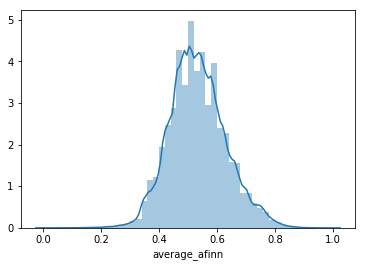

In [80]:
sns.distplot(afinn['average_afinn'])
plt.show()

In [81]:
vader = sent_scores[['id', 'comments', 'vader_sent_transformed']].join(whole_scores[['id', 'vader_transformed_clipped']].set_index('id'), on='id')

In [82]:
vader['average_vader'] = (sent_scores['vader_sent_transformed'].astype(float) + whole_scores['vader_transformed_clipped'].astype(float) )/2

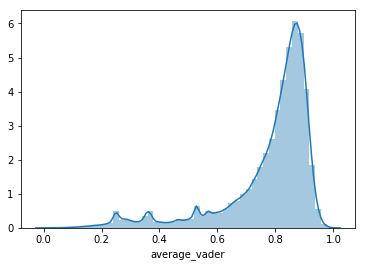

In [83]:
sns.distplot(vader['average_vader'])
plt.show()

In [84]:
s140 = sent_scores[['id', 'comments', 's140_sent']].join(whole_scores[['id', 's140']].set_index('id'), on='id')

In [85]:
s140['average_s140'] = (sent_scores['s140_sent'].astype(float) + whole_scores['s140'].astype(float) )/2

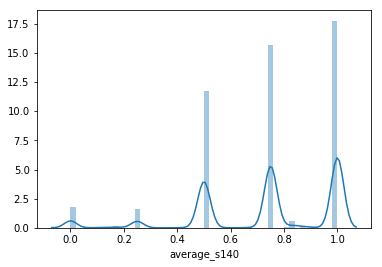

In [86]:
sns.distplot(s140['average_s140'])
plt.show()

In [87]:
so_cal = sent_scores[['id', 'comments', 'so_cal_sent_transformed_clipped']].join(whole_scores[['id', 'so_cal_transformed_clipped']].set_index('id'), on='id')

In [88]:
so_cal['average_so_cal'] = (sent_scores['so_cal_sent_transformed_clipped'].astype(float) + whole_scores['so_cal_transformed_clipped'].astype(float) )/2

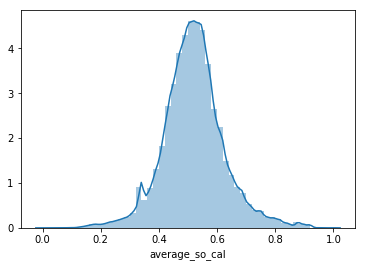

In [89]:
sns.distplot(so_cal['average_so_cal'])
plt.show()

In [90]:
opinion_bow = sent_scores[['id', 'comments', 'opinion_bow_sent_transformed']].join(whole_scores[['id', 'opinion_bow_transformed_clipped']].set_index('id'), on='id')

In [91]:
opinion_bow['average_opinion_bow'] = (sent_scores['opinion_bow_sent_transformed'].astype(float) + whole_scores['opinion_bow_transformed_clipped'].astype(float) )/2

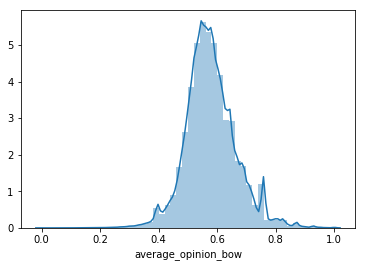

In [92]:
sns.distplot(opinion_bow['average_opinion_bow'])
plt.show()

In [93]:
avg_tools = [afinn, vader, s140, so_cal, opinion_bow]
voters_avg = ['average_afinn', 'average_vader', 'average_s140', 'average_so_cal', 'average_opinion_bow']
avg_table = join_multi_table(avg_tools, voters_avg)

In [694]:
a = pd.DataFrame({'id': [2,6,47,5]})

In [696]:
a[a.id < 5] = a[a.id < 5].id.map(lambda x : 'B')

In [697]:
a

,id
0,B
1,6
2,47
3,5


### Level 3

In [94]:
avg_table_levels3 =analysis.build_levels_table(avg_table, voters_avg, type=2)

In [95]:
voters_avg_level3 = [ "level3_"  + t for t in voters_avg] 

In [96]:
majority_vote_avg3 = majority_vote(avg_table_levels3, voters_avg_level3)

In [97]:
voter_counts(avg_table_levels3, voters_avg_level3)

,level3_average_afinn,level3_average_opinion_bow,level3_average_s140,level3_average_so_cal,level3_average_vader,total
0,189097,179843,108495,176593,84368,225090


### Level 5

In [98]:
avg_table_levels5 =analysis.build_levels_table(avg_table, voters_avg)

In [99]:
voters_avg_level5 = [ "level5_"  + t for t in voters_avg] 

In [100]:
majority_vote_avg5 = majority_vote(avg_table_levels5, voters_avg_level5)

In [101]:
voter_counts(avg_table_levels5, voters_avg_level5)

,level5_average_afinn,level5_average_opinion_bow,level5_average_s140,level5_average_so_cal,level5_average_vader,total
0,170004,166638,72420,174049,36545,225090


# Interrator Tools 

In [102]:
interrater_reviews = pd.read_csv('interrater/interrater_uq2.csv', index_col=0)

In [103]:
voters3 = sent_levels3_table[['id', 'comments'] + voters_sent_level3].join(whole_levels3_table[['id'] + voters_whole_level3].set_index('id'), on='id')

In [104]:
len(interrater_reviews)

70

In [105]:
test_interrater3 = interrater_reviews[['id', 'interrater_weighted_avg']].join(voters3.set_index('id'), on='id')

In [106]:
test_interrater3 = test_interrater3[~test_interrater3.comments.isnull()]

In [107]:
test_interrater3['interrater_weighted_avg'] = utils.minmaxscale(test_interrater3['interrater_weighted_avg'])

In [108]:
test_interrater3 = analysis.split_into_levels(test_interrater3, test_interrater3, 'interrater_weighted_avg', type=2)

In [109]:
test_interrater3.level3_interrater_weighted_avg.value_counts()

3    30
1    14
2     8
Name: level3_interrater_weighted_avg, dtype: int64

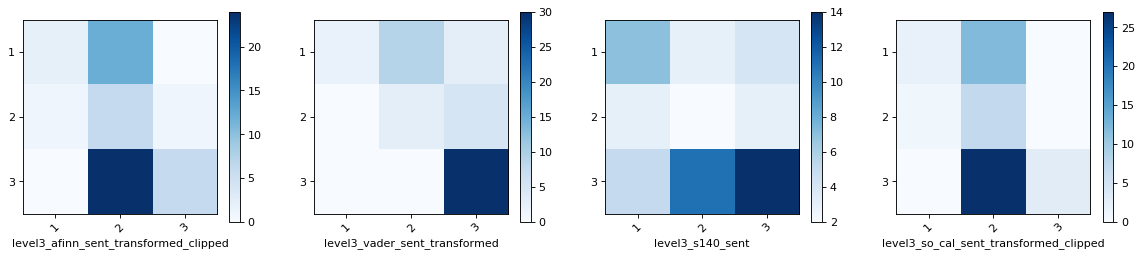

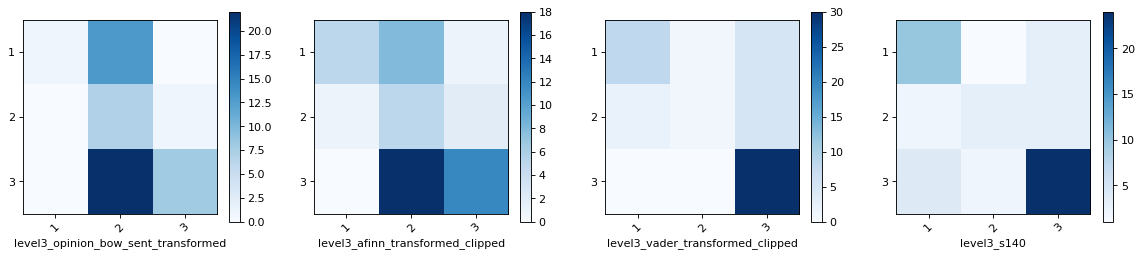

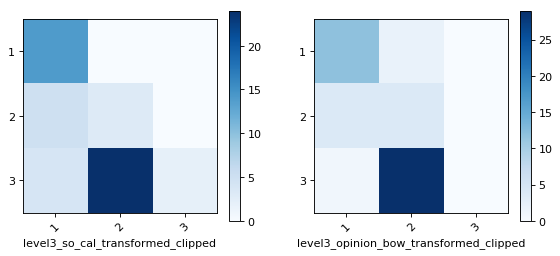

In [110]:
analysis.plot_confusion_matrix_grid(test_interrater3, 'level3_interrater_weighted_avg', combined_voters3)

### Level 5

In [111]:
voters5 = sent_levels5_table[['id', 'comments'] + voters_sent_level5].join(whole_levels5_table[['id'] + voters_whole_level5].set_index('id'), on='id')

In [112]:
test_interrater5 = interrater_reviews[['id', 'interrater_weighted_avg']].join(voters5.set_index('id'), on='id')

In [113]:
test_interrater5 = test_interrater5[~test_interrater5.comments.isnull()]

In [114]:
test_interrater5['interrater_weighted_avg'] = utils.minmaxscale(test_interrater5['interrater_weighted_avg'])

In [115]:
test_interrater5 = analysis.split_into_levels(test_interrater5, test_interrater5, 'interrater_weighted_avg')

In [116]:
test_interrater5.level5_interrater_weighted_avg.value_counts()

5    23
4     9
1     8
3     6
2     6
Name: level5_interrater_weighted_avg, dtype: int64

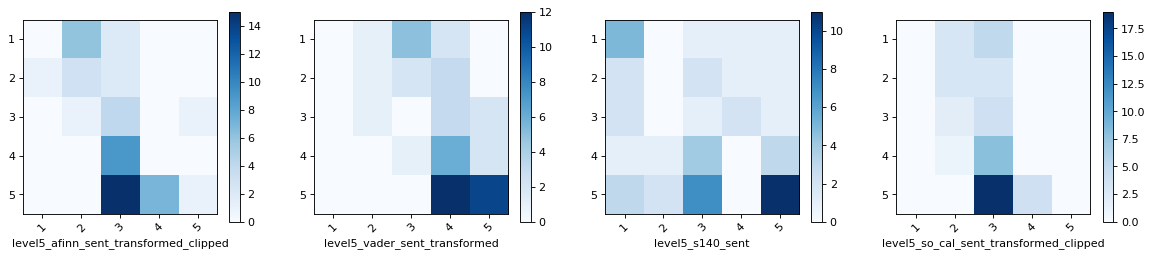

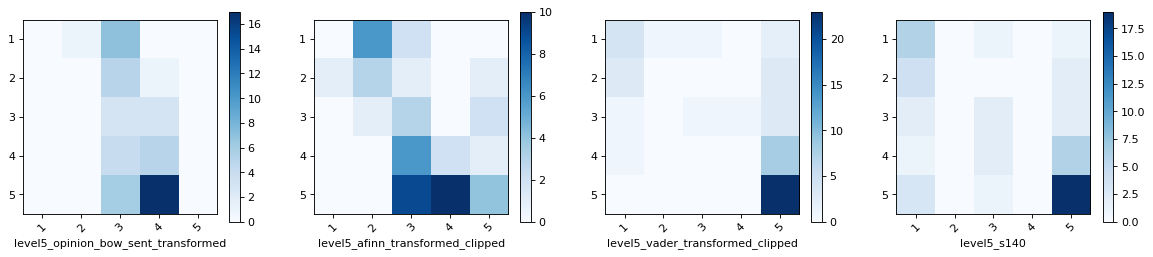

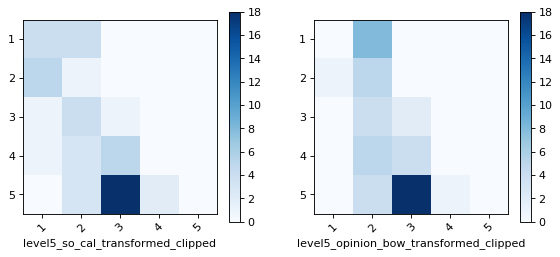

In [117]:
analysis.plot_confusion_matrix_grid(test_interrater5, 'level5_interrater_weighted_avg', combined_voters5)

c = combined_voting[['id', 'vote']].rename(columns={'vote': 'combined_vote'})
w = whole_table_levels[['id', 'vote']].rename(columns={'vote': 'whole_vote'})
s = sent_table_levels[['id', 'vote']].rename(columns={'vote': 'sent_vote'})

majority_voters = c.join(w.set_index('id'), on='id').join(s.set_index('id'), on='id')

test_majority_vote = test_interrater[['id', 'level_interrater_weighted_avg']].join(majority_voters.set_index('id'), on='id')

analysis.plot_confusion_matrix_grid(test_majority_vote, 'level_interrater_weighted_avg', ['whole_vote', 'sent_vote', 'combined_vote'])

In [118]:
test_avg_vote3 = test_interrater3[['id', 'level3_interrater_weighted_avg']].join(avg_table_levels3.set_index('id'), on='id')

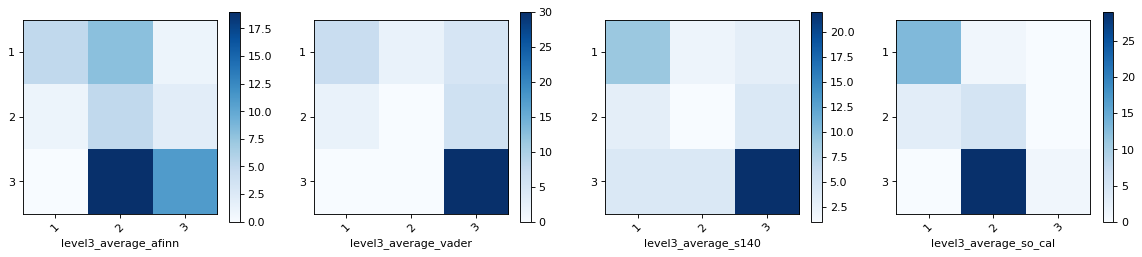

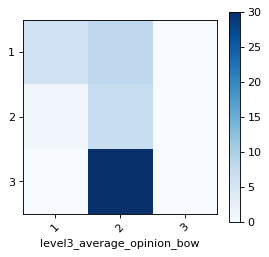

In [119]:
analysis.plot_confusion_matrix_grid(test_avg_vote3 , 'level3_interrater_weighted_avg', voters_avg_level3)

In [120]:
test_avg_vote5 = test_interrater5[['id', 'level5_interrater_weighted_avg']].join(avg_table_levels5.set_index('id'), on='id')

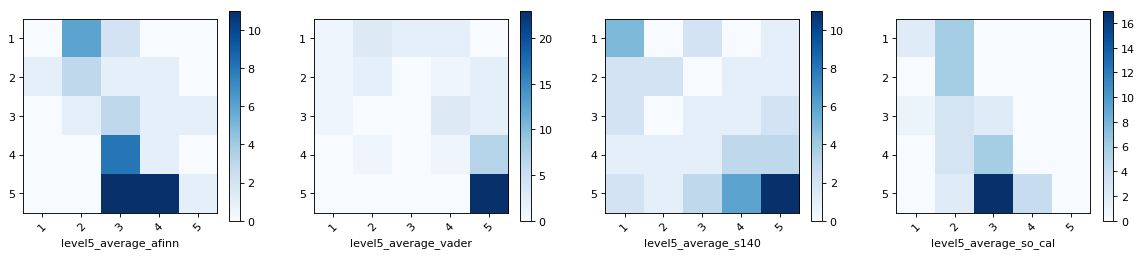

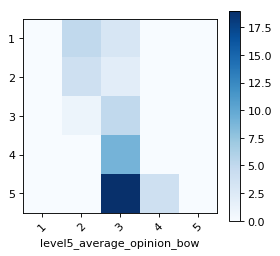

In [121]:
analysis.plot_confusion_matrix_grid(test_avg_vote5 , 'level5_interrater_weighted_avg', voters_avg_level5)

In [122]:
for a in voters_sent_level3:
    print("Error for %s : %.2f" % (a, analysis.rss(test_interrater3, 'level3_interrater_weighted_avg', a)))
    
    

Error for level3_afinn_sent_transformed_clipped : 38.00
Error for level3_vader_sent_transformed : 26.00
Error for level3_s140_sent : 56.00
Error for level3_so_cal_sent_transformed_clipped : 40.00
Error for level3_opinion_bow_sent_transformed : 36.00


In [123]:
for a in voters_sent_level5:
    print("Error for %s : %.2f" % (a, analysis.rss(test_interrater5, 'level5_interrater_weighted_avg', a)))
    
    

Error for level5_afinn_sent_transformed_clipped : 98.00
Error for level5_vader_sent_transformed : 80.00
Error for level5_s140_sent : 174.00
Error for level5_so_cal_sent_transformed_clipped : 120.00
Error for level5_opinion_bow_sent_transformed : 86.00


In [124]:
for a in voters_whole_level3:
    print("Error for %s : %.2f" % (a, analysis.rss(test_interrater3, 'level3_interrater_weighted_avg', a)))
    
    

Error for level3_afinn_transformed_clipped : 33.00
Error for level3_vader_transformed_clipped : 28.00
Error for level3_s140 : 36.00
Error for level3_so_cal_transformed_clipped : 45.00
Error for level3_opinion_bow_transformed_clipped : 39.00


In [125]:
for a in voters_whole_level5:
    print("Error for %s : %.2f" % (a, analysis.rss(test_interrater5, 'level5_interrater_weighted_avg', a)))
    
    

Error for level5_afinn_transformed_clipped : 87.00
Error for level5_vader_transformed_clipped : 101.00
Error for level5_s140 : 127.00
Error for level5_so_cal_transformed_clipped : 144.00
Error for level5_opinion_bow_transformed_clipped : 146.00


## Havent done majority yet 

In [126]:
for a in majority_voters:
    print("Error for %s : %.2f" % (a, analysis.rss(test_majority_vote, 'level_interrater_weighted_avg', a)))
    

NameError: name 'majority_voters' is not defined

In [1664]:
for a in voters_avg_level:
    print("Error for %s : %.2f" % (a, analysis.rss(test_avg_vote, 'level_interrater_weighted_avg', a)))
    

Error for level_average_afinn : 98.00
Error for level_average_vader : 74.00
Error for level_average_s140 : 132.00
Error for level_average_so_cal : 82.00
Error for level_average_opinion_bow : 102.00


In [1666]:
for a in ['level_avg']:
    print("Error for %s : %.2f" % (a, analysis.rss(test_best_score_avg, 'level_interrater_weighted_avg', a)))
    

Error for level_avg : 60.00


In [1667]:
for a in ['vote']:
    print("Error for %s : %.2f" % (a, analysis.rss(test_best_vote, 'level_interrater_weighted_avg', a)))
    

Error for vote : 78.00


In [151]:
combined_voting3.columns

Index(['id', 'comments', 'level3_afinn_sent_transformed_clipped',
       'level3_vader_sent_transformed', 'level3_s140_sent',
       'level3_so_cal_sent_transformed_clipped',
       'level3_opinion_bow_sent_transformed',
       'level3_afinn_transformed_clipped', 'level3_vader_transformed_clipped',
       'level3_s140', 'level3_so_cal_transformed_clipped',
       'level3_opinion_bow_transformed_clipped', 'vote'],
      dtype='object')

In [183]:
best_tools3 = ['level3_vader_sent_transformed', 'level3_so_cal_transformed_clipped', 'level3_afinn_transformed_clipped', 'level3_s140']
best_table3 = combined_voting3[['id', 'comments']+best_tools3]

In [184]:
 majority_vote_best3 = majority_vote(best_table3, best_tools3)

/Users/lynraybarends/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [185]:
test_best_vote3 = test_interrater3[['id', 'level3_interrater_weighted_avg']].join(majority_vote_best3[['id', 'comments', 'vote']].set_index('id'), on='id')

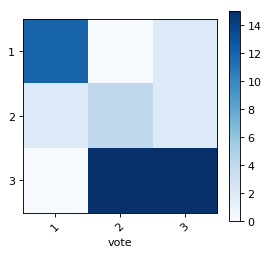

In [186]:
analysis.plot_confusion_matrix_grid(test_best_vote3 , 'level3_interrater_weighted_avg', ['vote'])

In [191]:
best_tools5 = ['level5_vader_sent_transformed', 'level5_so_cal_transformed_clipped', 'level5_afinn_transformed_clipped']
best_table5 = combined_voting5[['id', 'comments']+best_tools5]

In [192]:
 majority_vote_best5 = majority_vote(best_table5, best_tools5)

/Users/lynraybarends/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [193]:
test_best_vote5 = test_interrater5[['id', 'level5_interrater_weighted_avg']].join(majority_vote_best5[['id', 'comments', 'vote']].set_index('id'), on='id')

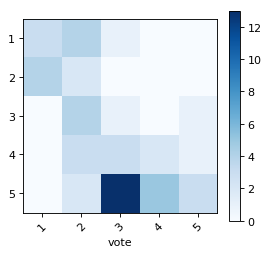

In [194]:
analysis.plot_confusion_matrix_grid(test_best_vote5 , 'level5_interrater_weighted_avg', ['vote'])

In [356]:
op.get_score("I fucking hate this place")

-0.6666666666666666

In [386]:
best_voters=['vader_sent', 'so_cal_transformed_clipped', 's140']

In [387]:
best_scores = combined_scores[['id', 'comments']+best_voters]

KeyError: "['vader_sent'] not in index"

In [388]:
best_scores['score'] = np.average(best_scores[best_voters].astype(float), axis=1)

KeyError: "['vader_sent' 'so_cal_transformed_clipped' 's140'] not in index"

In [382]:
best_scores = analysis.build_levels_table(best_scores, ['score'], type=2)

In [383]:
test_best_score3 = test_interrater3[['id', 'level3_interrater_weighted_avg']].join(best_scores.set_index('id'), on='id')

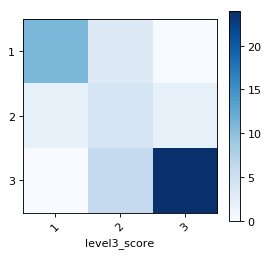

In [384]:
analysis.plot_confusion_matrix_grid(test_best_score3 , 'level3_interrater_weighted_avg', ['level3_score'])

In [385]:
best_scores[best_scores.level3_score == 1]

,id,comments,level3_score
232,6236,Dead cockroaches. Cat hair everywhere. Not very clean.,1
301,24023,"Although i was unable to make the stay due to an injury, addrienne was kind enough to give me a credit. I look forward to staying there in March.",1
304,61812,"Adrienne, I have just seen your review and it surprises me how can you be so accurate when you were never there or never met you. What do you mean the apartment was not well kept? It is true I made the next guest wait, for approximately 40 minutes if I recall and I apologized to him, and it was time I spent cleaning for him. What do you mean the guest did not fit through the hallway? This has to be figurative speech because he did fit and left his stuff in the room while he went to buy groceries during that time. And again it wasn't late at night (6 or 7 P.M., the time the other guest was arriving doesn't constitute late at night, at least for the standards in my country). As it says below, you have to state the facts or at least get them right. I hope you got rid of the ant infection in the bathroom and kitchen, because it was very annoying. Apart from that everything was OK!",1
324,1076344,if you want someone bothering you about using too many towels then stay here .,1
375,29344,"The apartment is not the place shown in the pictures, it was not clean, never met Akiko only her friend (Website hidden by Airbnb) unfortunetly I have nothing positive to say about my stay. Sorry, but I feel cheated!!",1
402,164743,"We would stay here again with Shun. Perfect location for NYC, easy to get around on foot and subway (5min walk to closest subway). 24hr conveient store downstairs, bottle shop, pharmacy not far. Shun was very quiet and kept to himself. For what you pay, I couldn't ask for anything else. Our plane was delayed because of the blizzard and didn't arrive till late at night. He let us in and made us a coffee!",1
446,852090,"My sister and I stayed in Shun's apt for 4 nights. The room is indeed located in a prime location - super convenient for any tourist needs and close to Times Square. Also located very close to a metro stop so getting around is very simple. The room itself was nice and plain. It is also adequately warm. There was a microwave, fridge, closet space, desk and even an extra heater. The bed and pillows were a little hard -- but spacious. The traffic outside can get a little loud. Like previous reviews, the hot water in the shower is a bit tricky, but I didn't have too much trouble figuring out how to get it to work. Shun is pretty private but is always ready to assist and help accomodate any needs/requests. We were usually gone all day so there was minimal interaction with the host. The overal experience was very positive and if I ever need lodgings in Manhattan again, I would definitely see if Shun's place is up for grabs. The only real criticism I have is that I didn't ...",1
468,1260860,"I arrived right around the time that I arranged with Shun to be there. Shun came down to the door and let me in. Perhaps he did this in order to lead me directly to the apartment the first time, as I might conceivably have gotten confused as to where the apartment is, due to the stairway and apartment layout. Anyway, first appearances of the building might be scary for some. It is rather run down. Indeed, the apartment must not have enough storage space because there are boxes lining the hallway leading to the main part of the apartment. The room is very basic, but is as advertised. There is a small refrigerator, some dishes and a microwave, a TV and WiFi. The apartment could use a cosmetic facelift, for sure, but apart from that, it was comfortable enough, though spartan. After introductions, I didn't see Shun again until shortly before I left. All in all, though I wouldn't necessarily recommend this for everyone, I would definitely return due to the convenience of location. Shun ...",1
481,2295972,"We've already stayed five times with airbnb and this was definitely t

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
stopwords.add("said")

wc = WordCloud(background_color="white", max_words=2000,
               stopwords=stopwords, contour_width=3, contour_color='steelblue')

# generate word cloud
wc.generate(blob)


# show
plt.imshow(wc, interpolation='bilinear')

import nltk

token_text = utils.tokenize(blob)
pos_tags =  nltk.pos_tag(token_text)
pos_dict = dict(nltk.Index((value, key) for (key,value) in pos_tags))

adjectives = ['JJ', 'JJR', 'JJS']

t = set(pos_dict['JJ'] + pos_dict['JJR'] + pos_dict['JJS'])

plt.show()

In [1644]:
best_tools_whole = ['transformed_afinn', 's140_norm', 'transformed_opinion_bow']
best_tools_sent = ['vader-sent_clipped_norm', 'transformed_so_cal_sent']
best_tools_score = best_tools_whole + best_tools_sent


In [1645]:
best_score_avg = whole_table[['id', 'comments']+best_tools_whole].join(sent_table[['id']+best_tools_sent].set_index('id'), on='id')

In [1646]:
best_score_avg['avg'] = np.average(best_score_avg[best_tools_score], axis=1)

In [1647]:
best_score_avg = analysis.build_levels_table(best_score_avg, ['avg'])

In [1649]:
test_best_score_avg = test_interrater[['id', 'level_interrater_weighted_avg']].join(best_score_avg.set_index('id'), on='id')

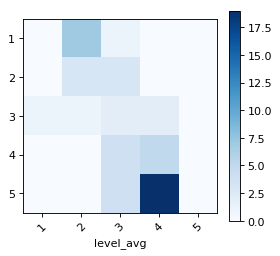

In [1650]:
analysis.plot_confusion_matrix_grid(test_best_score_avg , 'level_interrater_weighted_avg', ['level_avg'])

## Current Satisfaction Scores

In [1668]:
curr_sat = pd.read_csv('satisfaction_scores.csv', index_col=0)

In [1669]:
test_curr = test_interrater[['id', 'level_interrater_weighted_avg']].join(curr_sat[['id', 'satisfaction']].set_index('id'), on='id')

In [1674]:
test_curr = test_curr[~test_curr.satisfaction.isnull()]

In [1675]:
test_curr = analysis.split_into_levels(test_curr, test_curr,'satisfaction')

In [1677]:
for a in ['level_satisfaction']:
    print("Error for %s : %.2f" % (a, analysis.rss(test_curr, 'level_interrater_weighted_avg', a)))
    

Error for level_satisfaction : 53.00


# Extra + Normalisation

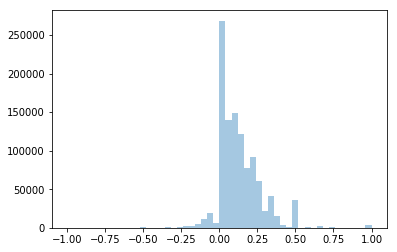

In [706]:
a = utils.flatten(reviews['opinion_freq-sent'])
sns.distplot(a, kde=False)
plt.show()

In [76]:
sent.print_anaysis(op_bow_sent_table, 264759774 , 'opinion_bow-sentence-adj-1-norm', 1)

Orhun was a very friendly host. Even though he wasn't there the four days I visited the city, he responded very quickly and mailed me all the details necessary to get to the apartment in a very comprehensive and easy way. Probably the best host I have had so far on Airbnb. Everyone who is able/willing to pay that price for an Airbnb should definitely take a look at it. Location is very central, directly located in the party/pub area. as well. All in all, great stay!

In [83]:
normalization = reviews[['idReview', 'id', 'date', 'reviewer_id', 'listing_id', 'recipient_id', 'comments', 'hostCancelled', 'token_len', 'num_of_sents',
       'google_langs', 'google_langs_conf', 'langdetect_langs',
       'langdetect_langs_conf', 'other_langs', 'translated',]]
normalization.is_copy = False

In [84]:
#Afinn
normalization[['afinn_norm_o', 'afinn_norm_clipo_o']] = afinn_table[afinn_chosen_o]
normalization[['afinn_norm_s', 'afinn_norm_clipi_s']] = afinn_sent_table[afinn_chosen_s]

In [85]:
# Vader
normalization[['vader_norm_o', 'vader_norm_clipo_o']] = vader_table[vader_chosen_o]
normalization[['vader_norm_s', 'vader_norm_clipi_s']] = vader_sent_table[vader_chosen_s]

In [86]:
# S140
normalization[['s140_norm_o']] = s140_table[s140_chosen_o]
normalization[['s140_norm_s']] = s140_sent_table[s140_chosen_s]

In [87]:
# Socal
normalization[['so_cal_norm_o', 'so_cal_norm_clipo_o']] = so_cal_table[so_cal_chosen_o]
normalization[['so_cal_norm_s', 'so_cal_norm_clipi_s']] = so_cal_sent_table[so_cal_chosen_s]

In [88]:
# Opinion Bow
normalization[['op_bow_norm_o', 'op_bow_norm_clipo_o']] = op_bow_table[op_bow_chosen_o]
normalization[['op_bow_norm_s', 'op_bow_norm_clipi_s']] = op_bow_sent_table[op_bow_chosen_s]

In [89]:
# Opinion Freq
normalization[['op_freq_norm_o', 'op_freq_norm_clipo_o']] = op_freq_table[op_freq_chosen_o]
normalization[['op_freq_norm_s', 'op_freq_norm_clipi_s']] = op_freq_sent_table[op_freq_chosen_s]

In [526]:
normalization.to_csv("score_backup.csv")

NameError: name 'normalization' is not defined

In [91]:
normalization.to_csv('reviews_normalisations.csv')

# Average by norm whole 2 versions

In [4]:
norm_reviews = pd.read_csv('reviews_normalisations.csv', index_col=0)

In [5]:
sent_norm_tools = ['afinn_norm_s', 'vader_norm_s', 's140_norm_s', 'so_cal_norm_s', 'op_bow_norm_s']
sent_adj_tools = ['afinn_norm_clipi_s', 'vader_norm_clipi_s', 'so_cal_norm_clipi_s', 'op_bow_norm_clipi_s']
whole_norm_tools = ['afinn_norm_o', 'vader_norm_o', 's140_norm_o', 'so_cal_norm_o','op_bow_norm_o']
whole_adj_tools = ['afinn_norm_clipo_o', 'vader_norm_clipo_o', 'so_cal_norm_clipo_o', 'op_bow_norm_clipo_o']
sent_tools = sent_norm_tools + sent_adj_tools
whole_tools = whole_norm_tools + whole_adj_tools

In [6]:
sentence_set = norm_reviews[['idReview', 'id', 'date', 'reviewer_id', 'listing_id', 'recipient_id',
       'comments', 'hostCancelled', 'token_len', 'num_of_sents',
       'google_langs', 'google_langs_conf', 'langdetect_langs',
       'langdetect_langs_conf', 'other_langs', 'translated']+ sent_tools]

In [69]:
sent.print_anaysis(so_cal_sent_table, 264759774 , 'so_cal-sentence-adj-1-norm', 1)

Orhun was a very friendly host. Even though he wasn't there the four days I visited the city, he responded very quickly and mailed me all the details necessary to get to the apartment in a very comprehensive and easy way. Probably the best host I have had so far on Airbnb. Everyone who is able/willing to pay that price for an Airbnb should definitely take a look at it. Location is very central, directly located in the party/pub area. as well. All in all, great stay!

In [7]:
whole_avgs_best = ['afinn_norm_clipo_o','vader_norm_clipo_o','s140_norm_o', 'so_cal_norm_clipo_o', 'op_bow_norm_o']
sent_avgs_best = ['afinn_norm_clipi_s','vader_norm_s','s140_norm_s', 'so_cal_norm_clipi_s', 'op_bow_norm_s']
best_of_each = ['afinn_norm_clipo_o','vader_norm_s','s140_norm_s', 'so_cal_norm_o', 'op_bow_norm_o']
match_1 = list(set(whole_avgs_best) - set(['s140_norm_o']))
match_2 = list(set(sent_avgs_best) - set(['s140_norm_s']))
match_3 = list(set(best_of_each) - set(['s140_norm_s']))
match_4 = ['vader_norm_clipo_o', 'vader_norm_s']
match_5 = ['afinn_norm_clipo_o', 'afinn_norm_clipi_s']
match_6 = match_4 + match_5
match_7 = match_6 + ['so_cal_norm_clipi_s']
match_8 = match_4 + ['afinn_norm_clipo_o']
match_9 = match_6 + ['s140_norm_s']
match_10 = match_6 + ['so_cal_norm_clipo_o']
match_11 = match_4 + ['so_cal_norm_clipo_o']
match_12 = ['vader_norm_clipo_o', 'afinn_norm_clipo_o']
match_13 = match_12 + ['so_cal_norm_clipo_o']

In [8]:
avg_table = norm_reviews[['id','comments',  'token_len', 'num_of_sents', 'google_langs']]
avg_sent_table = norm_reviews[['id','comments',  'token_len', 'num_of_sents', 'google_langs']]
avg_sent_table.is_copy = False
avg_table.is_copy = False

In [9]:
avg_table['avg_whole_norm'] = np.sum(norm_reviews[whole_norm_tools], axis=1)/5
avg_table['avg_whole_adj'] = np.sum(norm_reviews[whole_adj_tools], axis=1)/4
avg_table['avg_whole_best'] = np.sum(norm_reviews[whole_avgs_best], axis=1)/5
avg_table['avg_best_of_each'] = np.sum(norm_reviews[best_of_each], axis=1)/5

In [12]:
sentence_set[list((set(sent_norm_tools)).union(set(sent_adj_tools)))] = sentence_set[list((set(sent_norm_tools)).union(set(sent_adj_tools)))].applymap(lambda x : utils.str_to_list(x))

/Users/lynraybarends/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [14]:
sentence_set[sent_norm_tools].head()

,afinn_norm_s,vader_norm_s,s140_norm_s,so_cal_norm_s,op_bow_norm_s
201,[0.403],[0.929],[0.5],[0.374],[0.75]
202,"[0.387, 0.355, 0.323, 0.323, 0.387]","[0.813, 0.498, 0.472, 0.421, 0.83]","[0.5, 0.5, 0.5, 0.5, 0.5]","[0.388, 0.397, 0.37, 0.325, 0.434]","[0.667, 0.667, 0.556, 0.5, 0.667]"
203,"[0.403, 0.387, 0.371, 0.387, 0.371]","[0.851, 0.885, 0.738, 0.83, 0.68]","[0.5, 0.5, 0.5, 0.5, 0.5]","[0.365, 0.394, 0.37, 0.434, 0.342]","[0.643, 0.55, 0.75, 0.75, 0.6]"
204,"[0.403, 0.452, 0.371, 0.435, 0.387, 0.403, 0.3...","[0.919, 0.91, 0.836, 0.885, 0.813, 0.777, 0.83...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]","[0.369, 0.4, 0.365, 0.376, 0.388, 0.377, 0.434...","[0.556, 0.714, 0.667, 0.875, 0.667, 0.625, 0.7..."
205,"[0.484, 0.387, 0.323, 0.371]","[0.942, 0.813, 0.485, 0.71]","[1.0, 0.5, 0.5, 0.5]","[0.388, 0.388, 0.34, 0.342]","[0.7, 0.75, 0.5, 0.571]"


In [18]:
avg_sent_table['sent_avgs_norm'] = sentence_set[sent_norm_tools].sum(axis=1)/len(sent_norm_tools)
avg_sent_table['sent_avgs_adj'] = sentence_set[sent_adj_tools].sum(axis=1)/len(sent_adj_tools)
avg_sent_table['sent_avgs_best'] = sentence_set[sent_avgs_best].sum(axis=1)/len(sent_avgs_best)

In [21]:
avg_table['avg_sent_norm'] = sent.reduce_to_average(avg_sent_table['sent_avgs_norm'])
avg_table['avg_sent_adj'] = sent.reduce_to_average(avg_sent_table['sent_avgs_adj'])
avg_table['avg_sent_best'] = sent.reduce_to_average(avg_sent_table['sent_avgs_best'])

In [45]:
norm_reviews = sent.reduce_sentence_scores(norm_reviews, sent_tools, True)

In [50]:
norm_reviews[sent_tools] = norm_reviews[sent_tools].astype(float)

In [51]:
avg_table['avg_match_1'] = np.array(np.sum(norm_reviews[match_1], axis=1))/len(match_1)
avg_table['avg_match_2'] = np.array(np.sum(norm_reviews[match_2], axis=1))/len(match_2)
avg_table['avg_match_3'] = np.array(np.sum(norm_reviews[match_3], axis=1))/len(match_3)
avg_table['avg_match_4'] = np.array(np.sum(norm_reviews[match_4], axis=1))/len(match_4)
avg_table['avg_match_5'] = np.array(np.sum(norm_reviews[match_5], axis=1))/len(match_5)
avg_table['avg_match_6'] = np.array(np.sum(norm_reviews[match_6], axis=1))/len(match_6)
avg_table['avg_match_7'] = np.array(np.sum(norm_reviews[match_7], axis=1))/len(match_7)
avg_table['avg_match_8'] = np.array(np.sum(norm_reviews[match_8], axis=1))/len(match_8)
avg_table['avg_match_9'] = np.array(np.sum(norm_reviews[match_9], axis=1))/len(match_9)
avg_table['avg_match_10'] = np.array(np.sum(norm_reviews[match_10], axis=1))/len(match_10)
avg_table['avg_match_11'] = np.array(np.sum(norm_reviews[match_11], axis=1))/len(match_11)
avg_table['avg_match_12'] = np.array(np.sum(norm_reviews[match_12], axis=1))/len(match_12)
avg_table['avg_match_13'] = np.array(np.sum(norm_reviews[match_13], axis=1))/len(match_13)

In [53]:
avg_tools = ['avg_match_1','avg_match_2','avg_match_3','avg_match_4','avg_match_5','avg_match_6','avg_match_7',
             'avg_match_8','avg_match_9','avg_match_10','avg_match_11','avg_match_12','avg_match_13','avg_sent_norm','avg_sent_adj','avg_sent_best','avg_whole_norm','avg_whole_adj','avg_whole_best', 'avg_best_of_each']


In [54]:
avg_table[avg_tools] = avg_table[avg_tools].astype(float)

In [109]:
avg_table[(avg_table['avg_whole_norm'] <0.3)]

,id,comments,token_len,num_of_sents,google_langs,avg_whole_norm,avg_whole_adj,avg_whole_best,avg_best_of_each,avg_sent_norm,avg_sent_adj,avg_sent_best,avg_match_1,avg_match_2,avg_match_3,avg_match_4,avg_match_5,avg_match_6,avg_match_7,avg_match_8,avg_match_9,avg_match_10,avg_match_11,avg_match_12,avg_match_13
232,6236,Dead cockroaches. Cat hair everywhere. Not ver...,8,3,en,0.260298,0.146986,0.176168,0.258454,0.412,0.325,0.396,0.220211,0.36950,0.405567,0.1650,0.324940,0.244970,0.238176,0.208627,0.295976,0.195976,0.110000,0.147940,0.098627
375,29344,The apartment is not the place shown in the pi...,39,3,en,0.273896,0.172489,0.196571,0.275544,0.346,0.298,0.341,0.245713,0.34325,0.428930,0.1690,0.362791,0.265896,0.258717,0.222528,0.279317,0.226378,0.135436,0.164791,0.132630
384,69674,We stayed at Shun's place for a week in july. ...,97,8,en,0.276642,0.174527,0.200677,0.277534,0.418,0.381,0.426,0.250846,0.42275,0.466918,0.2400,0.368650,0.304325,0.308060,0.275433,0.331060,0.260079,0.187698,0.173150,0.143131
481,2295972,We've already stayed five times with airbnb an...,82,5,en,0.225142,0.074890,0.134379,0.207693,0.365,0.227,0.326,0.167974,0.28225,0.338867,0.1585,0.210160,0.184330,0.173264,0.158107,0.247464,0.147464,0.105667,0.078660,0.052440
538,12649702,My first experience with Airbnb in this apartm...,330,15,en,0.241306,0.086892,0.135601,0.221120,0.374,0.341,0.362,0.169501,0.38525,0.395400,0.2380,0.214370,0.226185,0.233948,0.193247,0.234348,0.185461,0.166188,0.051870,0.042102
561,20676723,This place is horrible and not what is represe...,22,3,en,0.196904,0.043745,0.123110,0.183846,0.243,0.109,0.179,0.153888,0.18175,0.286307,0.1130,0.191990,0.152495,0.121996,0.133660,0.155396,0.121996,0.075333,0.087490,0.058326
587,31027432,He is very quiet but gave no idea about the ar...,42,3,en,0.271267,0.153246,0.181176,0.266341,0.347,0.332,0.332,0.226470,0.37275,0.432176,0.1985,0.324940,0.261720,0.252976,0.230960,0.242776,0.214384,0.140680,0.147940,0.106973
606,41269884,Our apartment building in Philadelphia caught ...,159,6,en,0.257577,0.138452,0.173960,0.244059,0.364,0.329,0.360,0.217450,0.36675,0.410324,0.2105,0.238490,0.224495,0.245796,0.198660,0.246196,0.205660,0.183774,0.087490,0.101767
1780,2838353,"SHOCKING describes best the place, beginning w...",256,16,en,0.285734,0.205235,0.220537,0.290915,0.420,0.395,0.429,0.275672,0.43525,0.491894,0.2565,0.385234,0.320867,0.323294,0.297489,0.337894,0.282369,0.213792,0.189734,0.169281
2143,108810133,DO NOT GO HERE! I wouldn't recommend this plac...,239,20,en,0.240116,0.112347,0.148457,0.225740,0.373,0.310,0.360,0.185571,0.35550,0.374425,0.1845,0.252160,0.218330,0.219264,0.175440,0.249664,0.174664,0.123000,0.078660,0.052440


In [212]:
avg_table.to_csv('sent_avgs.csv')

In [213]:
len(avg_table)

225448

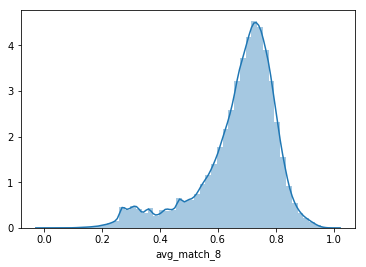

In [104]:
sns.distplot(avg_table['avg_match_8'])
plt.show()

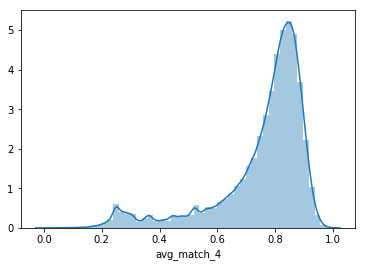

In [216]:
sns.distplot(avg_table['avg_match_4'])
plt.show()

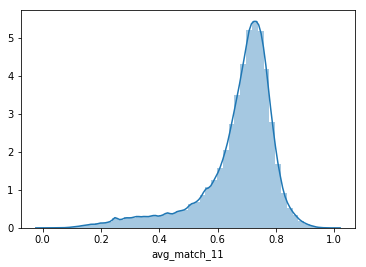

In [106]:
sns.distplot(avg_table['avg_match_11'])
plt.show()

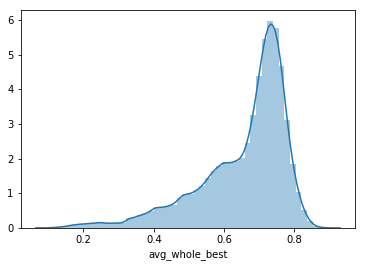

In [111]:
sns.distplot(avg_table['avg_whole_best'])
plt.show()

In [158]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
stopWords = set(stopwords.words('english'))

In [208]:
bad_reviews = vader_table[(vader_table['vader-norm'] <0.2)]

In [209]:
r, vc, v, idf = lang.pipeline(bad_reviews['comments'], stopWords)

In [210]:
vocab_table = lang.create_vocab_count_table(vc)

In [211]:
vocab_table.sort_values(by='counts', ascending=False).head(40)

,counts,word
6,1732,apartment
7,928,place
100,833,us
85,723,host
21,713,stay
55,681,room
173,672,one
104,619,would
16,555,airbnb
54,527,night


# Comparison 

In [102]:
utils.get_comments(norm_reviews, 'id', 106703, 'comments')

"Is glad to stay in Tina's Apt. the apt is just closed to the convinent store (around the corner), food (1 block away) and take another 7 to 10 blocks to times square.."

# Opinion-Freq Sentence

In [742]:
op_freq_sent_table = utils.transform_score_sent(reviews, 'opinion_freq-sent')

In [743]:
op_freq_sent_table.head()

,id,comments,token_len,num_of_sents,opinion_freq-sent,opinion_freq-sent-ndist,opinion_freq-sent-norm,opinion_freq-sent-ndist-norm
202,248421191,Robin’s place was great. Very spacious and we ...,55,5,"[0.2, 0.1111111111111111, 0.04, 0.0, 0.1666666...","[0.7884573603642703, 0.7472144018302211, 0.712...","[0.600, 0.556, 0.520, 0.500, 0.583]","[0.718, 0.680, 0.649, 0.631, 0.704]"
203,22938,Good location - easy access to Times Square an...,40,5,"[0.2, 0.058823529411764705, 0.25, 0.5, 0.14285...","[0.7884573603642703, 0.7221347174331975, 0.810...","[0.600, 0.529, 0.625, 0.750, 0.571]","[0.718, 0.657, 0.738, 0.834, 0.694]"
204,234213,We had the best possible time in NYC and Russe...,88,8,"[0.058823529411764705, 0.21428571428571427, 0....","[0.7221347174331975, 0.7949298748698876, 0.762...","[0.529, 0.607, 0.571, 0.650, 0.571, 0.571, 0.6...","[0.657, 0.724, 0.694, 0.758, 0.694, 0.694, 0.7..."
205,264416,Three of us stayed at this place for a week- i...,43,4,"[0.23529411764705882, 0.3333333333333333, 0.0,...","[0.8043728156701697, 0.8472978603872034, 0.693...","[0.618, 0.667, 0.500, 0.538]","[0.732, 0.771, 0.631, 0.665]"
206,843520,A great apartment in the perfect location. I w...,20,2,"[0.2857142857142857, 0.0]","[0.8266785731844679, 0.6931471805599453]","[0.643, 0.500]","[0.752, 0.631]"


In [744]:
opinion_freq_reduce = op_freq_sent_table[['id', 'comments', 'opinion_freq-sent-norm', 'opinion_freq-sent-ndist-norm']]

In [745]:
opinion_freq_reduce = sent.reduce_sentence_scores(opinion_freq_reduce,['opinion_freq-sent-norm', 'opinion_freq-sent-ndist-norm'] )

In [746]:
opinion_freq_reduce = analysis.split_into_levels(opinion_freq_reduce, opinion_freq_reduce, 'opinion_freq-sent-ndist-norm')

In [747]:
opinion_freq_reduce['level_opinion_freq-sent-ndist-norm'].value_counts()

4    221009
5      3688
3       386
2         7
Name: level_opinion_freq-sent-ndist-norm, dtype: int64

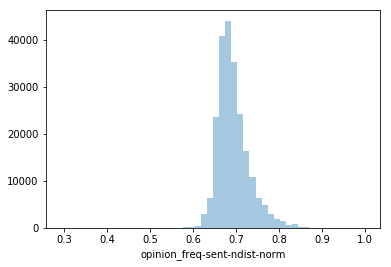

In [748]:
sns.distplot(opinion_freq_reduce['opinion_freq-sent-ndist-norm'].astype(float), kde=False)
plt.show()

In [721]:
op_freq_chosen_s = ['opinion_freq-sentence-norm', 'opinion_freq-sentence-adj-2-norm']